In [1]:
%load_ext autoreload
%autoreload 2

# Results

In [2]:
import os
import re
import itertools
from tqdm import tqdm
import warnings

import numpy as np
import pandas as pd
from scipy import stats

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import rgb_to_hsv,hsv_to_rgb, to_rgb
from matplotlib.legend_handler import HandlerTuple

from library import architectures, tools, evals, dataset, losses

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def get_training_log(log_path, log_item = 'Loss/train'):
    # log_path = f"./_models/{scale}/_s42/{arch}/{approach}/Logs"
    onlyfiles = [f for f in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, f))]
    log_file = onlyfiles[-1]

    event_acc = EventAccumulator(os.path.join(log_path, log_file))
    event_acc.Reload()

    logs = [e.value for e in event_acc.Scalars(log_item)]

    return logs

## Large-scale experiments

### Initialize

#### Variables

In [3]:
SCALE = 'LargeScale'
ARCHITECTURE = 'ResNet_50'  
training_info = tools.load_yaml('./config/train.yaml')

approaches_abbr = {'SoftMax':'SM','EOS':'EOS','OvR':'OvR','OpenSetOvR':'DSOvR'}
approaches_full = {'SoftMax':'SoftMax Loss','EOS':'Enropic Open-Set Loss','OvR':'One-vs-Rest Loss','OpenSetOvR':'Open-Set OvR Loss'}
seeds = [42]
num_classes = [116, 30, 151]

CMAP_t10 = mpl.color_sequences['tab10']
CMAP_t20 = mpl.color_sequences['tab20']
CMAP_s1 = mpl.color_sequences['Set1']
CMAP_s2 = mpl.color_sequences['Set2']

#### Evaluation data from SM

In [4]:
sm_data_info_1 = [
    [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'}
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'}
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'}
    ],
]

#### Evaluation data from EOS

In [5]:
eos_data_info_3 = [
    [
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg)'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg)'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg)'},
    ]
]

#### Evaluation data from OvR

In [6]:
ovr_data_info_1 = [
    [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
    ]
]

In [7]:
ovr_data_info_2_T = [
    None,
    {
        'C':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C (b)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C (g)'},],
        'F':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F (1)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OvR'], 'label': 'OvR-F (2)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OvR'], 'label': 'OvR-F (3)'},],
        'M':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OvR'], 'label': 'OvR-H (0.4)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-H (0.6)'},]
    },
    None
]

ovr_data_info_2 = [
    [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
        {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C'},
        {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F'},
        {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OvR'], 'label': 'OvR-H'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
        {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C'},
        {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F'},
        {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OvR'], 'label': 'OvR-H'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
        {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C'},
        {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F'},
        {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OvR'], 'label': 'OvR-H'},
    ],
]

In [8]:
ovr_data_info_3_T =[
    None,
    {
        'C' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (b w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (g w/ neg)'},],
        'F' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OvR'], 'label': 'OvR-F (1 w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OvR'], 'label': 'OvR-F (2 w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (3 w/ neg)'},],
        'M' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-H (0.4 w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg)'},]
    },
    None
]

ovr_data_info_3 = [
    [
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR (w/ neg)'},
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (w/ neg)'},
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (w/ neg)'},
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (w/ neg)'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR (w/ neg)'},
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (w/ neg)'},
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (w/ neg)'},
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (w/ neg)'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR (w/ neg)'},
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (w/ neg)'},
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (w/ neg)'},
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (w/ neg)'},
    ]
]

#### Evaluation data from DSOvR

In [9]:
dsovr_data_info_0_T = [
    [
        None
    ],
    [
        {'info':[f"{SCALE}_2", '_Tuning', f'{ARCHITECTURE}_sigma_neg_0_6', 'OpenSetOvR'], 'label': 'DSOvR (6)'},
        {'info':[f"{SCALE}_2", '_Tuning', f'{ARCHITECTURE}_sigma_neg_0_8', 'OpenSetOvR'], 'label': 'DSOvR (8)'},
        {'info':[f"{SCALE}_2", '_Tuning', f'{ARCHITECTURE}_sigma_neg_0_12', 'OpenSetOvR'], 'label': 'DSOvR (12)'},
    ],
    [
        None
    ]
]

In [10]:
dsovr_data_info_1 = [
    [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'DSOvR'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'DSOvR'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'DSOvR'},
    ]
]

In [11]:
dsovr_data_info_2_T = [
    None,
    {
        'C':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OpenSetOvR'], 'label': 'DSOvR-C (b)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OpenSetOvR'], 'label': 'DSOvR-C (g)'},],
        'F':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OpenSetOvR'], 'label': 'DSOvR-F (1)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OpenSetOvR'], 'label': 'DSOvR-F (2)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OpenSetOvR'], 'label': 'DSOvR-F (3)'},],
        'M':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OpenSetOvR'], 'label': 'DSOvR-H (0.4)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OpenSetOvR'], 'label': 'DSOvR-H (0.6)'},]
    },
    None
]

dsovr_data_info_2 = [
    [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'DSOvR'},
        {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OpenSetOvR'], 'label': 'DSOvR-C'},
        {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OpenSetOvR'], 'label': 'DSOvR-F'},
        {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OpenSetOvR'], 'label': 'DSOvR-H'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'DSOvR'},
        {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OpenSetOvR'], 'label': 'DSOvR-C'},
        {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OpenSetOvR'], 'label': 'DSOvR-F'},
        {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OpenSetOvR'], 'label': 'DSOvR-H'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'DSOvR'},
        {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OpenSetOvR'], 'label': 'DSOvR-C'},
        {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OpenSetOvR'], 'label': 'DSOvR-F'},
        {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OpenSetOvR'], 'label': 'DSOvR-H'},
    ],
]

In [12]:
dsovr_data_info_3_T =[
    None,
    {
        'C' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OpenSetOvR'], 'label': 'DSOvR-C (b w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OpenSetOvR'], 'label': 'DSOvR-C (g w/ neg)'},],
        'F' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OpenSetOvR'], 'label': 'DSOvR-F (1 w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OpenSetOvR'], 'label': 'DSOvR-F (2 w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OpenSetOvR'], 'label': 'DSOvR-F (3 w/ neg)'},],
        'M' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OpenSetOvR'], 'label': 'DSOvR-H (0.4 w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OpenSetOvR'], 'label': 'DSOvR-H (0.6 w/ neg)'},]
    },
    None
]

dsovr_data_info_3 = [
    [
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OpenSetOvR'], 'label': 'DSOvR (w/ neg)'},
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OpenSetOvR'], 'label': 'DSOvR-C (w/ neg)'},
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OpenSetOvR'], 'label': 'DSOvR-F (w/ neg)'},
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OpenSetOvR'], 'label': 'DSOvR-H (w/ neg)'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OpenSetOvR'], 'label': 'DSOvR (w/ neg)'},
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OpenSetOvR'], 'label': 'DSOvR-C (w/ neg)'},
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OpenSetOvR'], 'label': 'DSOvR-F (w/ neg)'},
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OpenSetOvR'], 'label': 'DSOvR-H (w/ neg)'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OpenSetOvR'], 'label': 'DSOvR (w/ neg)'},
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OpenSetOvR'], 'label': 'DSOvR-C (w/ neg)'},
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OpenSetOvR'], 'label': 'DSOvR-F (w/ neg)'},
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OpenSetOvR'], 'label': 'DSOvR-H (w/ neg)'},
    ]
]

### 0. Tuning

In [14]:
PROTOCOL = 2

#### DSOvR - neg 0 - Sigma
- Best = 8

In [15]:
data_info = dsovr_data_info_0_T[PROTOCOL-1]

# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0368	0.2460	0.6279	0.7073
0.0176	0.3240	0.6384	0.7409
0.0031	0.6260	0.6134	0.7167


#### Loss weighting - neg 0 - C, F, M 
- Best C (OvR/DSOvR) : global / global
- Best F (OvR/DSOvR) : 1 / 1
- Best M (OvR/DSOvR) : 0.4 / 0.4

In [16]:
data_info = dsovr_data_info_2_T[PROTOCOL-1]['C']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.1030	0.1127	0.5872	0.6929
0.1437	0.1200	0.5757	0.6948


In [17]:
data_info = dsovr_data_info_2_T[PROTOCOL-1]['F']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0162	0.3113	0.6603	0.7508
0.0180	0.3333	0.6511	0.7480
0.0215	0.3100	0.6498	0.7473


In [18]:
data_info = dsovr_data_info_2_T[PROTOCOL-1]['M']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0483	0.2593	0.5921	0.6929
0.1047	0.1893	0.5505	0.6715


In [19]:
data_info = ovr_data_info_2_T[PROTOCOL-1]['C']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.1568	0.1160	0.5770	0.6993
0.1242	0.1320	0.6007	0.7066


In [20]:
data_info = ovr_data_info_2_T[PROTOCOL-1]['F']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0152	0.3700	0.6377	0.7362
0.0152	0.3793	0.6213	0.7311
0.0152	0.4040	0.6226	0.7308


In [21]:
data_info = ovr_data_info_2_T[PROTOCOL-1]['M']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0512	0.2613	0.6020	0.7033
0.1483	0.1653	0.5577	0.6776


#### Loss weighting - neg All - C, F, M 
- Best C (OvR/DSOvR) : global / batch
- Best F (OvR/DSOvR) : 3 / 1
- Best M (OvR/DSOvR) : 0.6 / 0.6

In [22]:
data_info = dsovr_data_info_3_T[PROTOCOL-1]['C']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0338	0.2540	0.6961	0.7214
0.0338	0.2487	0.7033	0.7207


In [23]:
data_info = dsovr_data_info_3_T[PROTOCOL-1]['F']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0052	0.4660	0.7479	0.7546
0.0058	0.5033	0.7177	0.7381
0.0062	0.5267	0.6993	0.7259


In [24]:
data_info = dsovr_data_info_3_T[PROTOCOL-1]['M']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0201	0.3293	0.7193	0.7233
0.0327	0.2353	0.7351	0.7301


In [25]:
data_info = ovr_data_info_3_T[PROTOCOL-1]['C']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0393	0.2407	0.7056	0.7231
0.0486	0.2100	0.7170	0.7325


In [26]:
data_info = ovr_data_info_3_T[PROTOCOL-1]['F']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0071	0.4847	0.7167	0.7299
0.0061	0.5013	0.7125	0.7304
0.0057	0.5080	0.7256	0.7395


In [27]:
data_info = ovr_data_info_3_T[PROTOCOL-1]['M']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0188	0.3120	0.7367	0.7468
0.0313	0.2620	0.7252	0.7461


### Result 4-1. Multiclass classifier vs. a set of One-vs-Rest classifiers

RQ1. Can a set of one-vs-rest classifiers effectively replace a single multiclass classifier in neural networks for image classification tasks?

SM vs. OvR vs. DSOvR.
- Accuracy
- Confusion Matrix with '-1'
- Score distribution
    - Target = P_c
    - Non-Target = max{t is not c}P_t
    - Negative = max{t}P_t
    - Unknown = max{t}P_t
- |FPR-FNR|
- OSCR Curve
- OSA Curve


#### Protocol 1

In [366]:
PROTOCOL = 1

In [367]:
data_info = sm_data_info_1[PROTOCOL-1] + ovr_data_info_1[PROTOCOL-1] + dsovr_data_info_1[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']


In [369]:
results = evals.print_metrics(data_info, has_neg=False)

FPR↓	FNR↓	maxOSA_U↑
0.0032	0.3497	0.7623
0.0020	0.3460	0.7916
0.0020	0.3378	0.7784


[22.36206897  2.94827586  2.          1.89655172] [52.75862069  3.03448276  2.75862069  1.67241379]
[22.72413793  2.72413793  1.98275862  1.44827586] [57.39655172  6.03448276  4.29310345  2.51724138]
[18.44827586  3.32758621  2.10344828  1.74137931] [49.60344828  7.79310345  5.53448276  3.5862069 ]


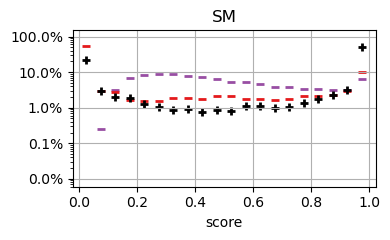

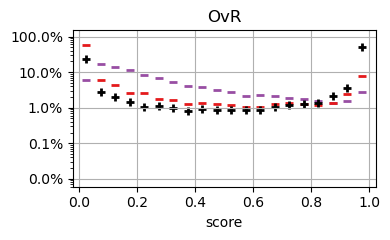

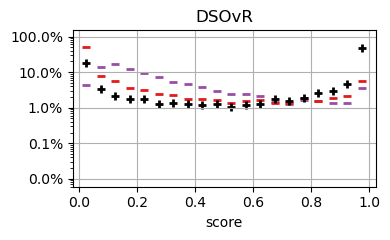

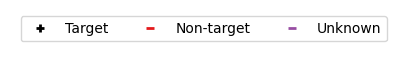

In [370]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

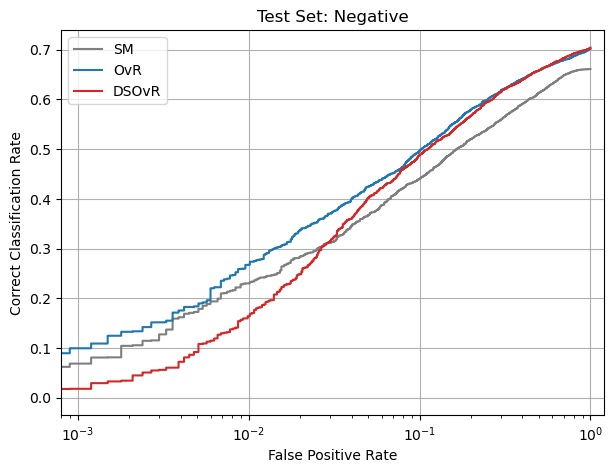

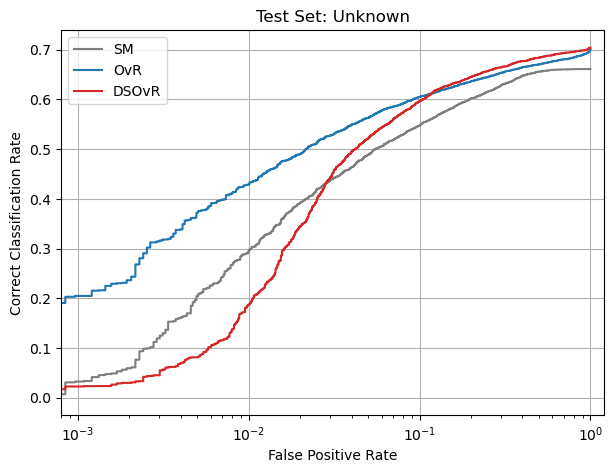

In [372]:
colors = [CMAP_t10[7],CMAP_t10[0],CMAP_t10[3]]
evals.plot_OSCR(data_info, colors, figsize=(7,5), show_val=False)

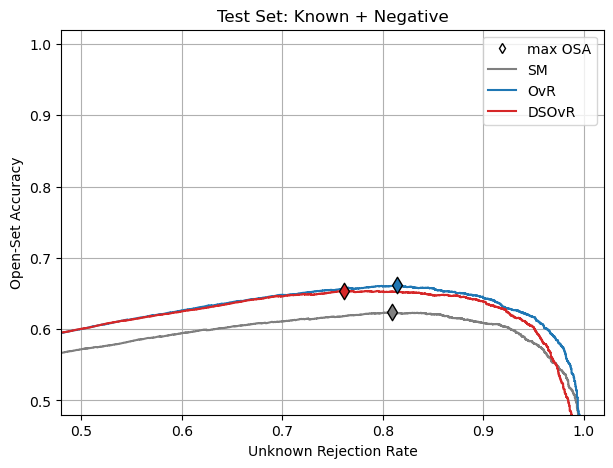

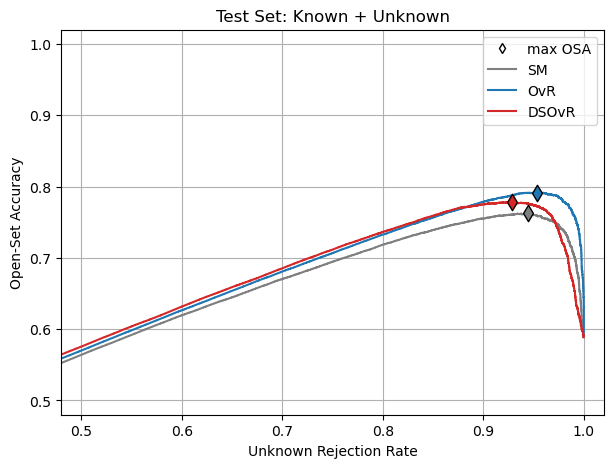

In [373]:
colors = [CMAP_t10[7],CMAP_t10[0],CMAP_t10[3]]
evals.plot_OSAC(data_info, colors, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

#### Protocol 2

In [374]:
PROTOCOL = 2

In [375]:
data_info = sm_data_info_1[PROTOCOL-1] + ovr_data_info_1[PROTOCOL-1] + dsovr_data_info_1[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']


In [377]:
results = evals.print_metrics(data_info, has_neg=False)

FPR↓	FNR↓	maxOSA_U↑
0.0209	0.3620	0.7273
0.0153	0.3620	0.7259
0.0176	0.3240	0.7409


[20.73333333  3.53333333  2.53333333  1.86666667] [50.86666667  3.73333333  2.6         1.93333333]
[19.13333333  4.33333333  2.46666667  2.8       ] [44.6         8.4         5.46666667  4.73333333]
[19.73333333  2.66666667  1.6         1.53333333] [55.06666667  4.4         2.73333333  2.73333333]


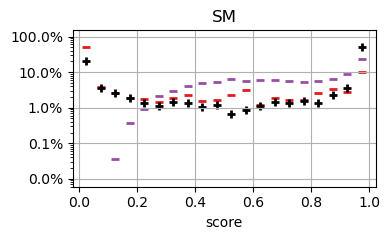

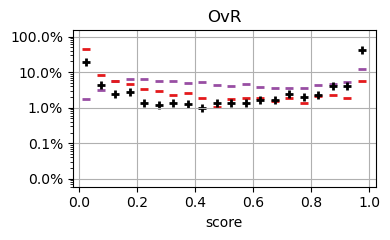

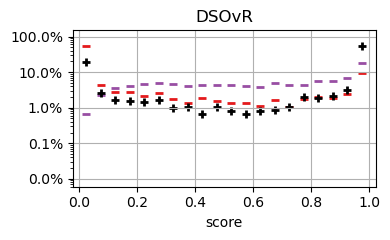

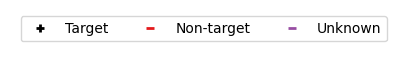

In [378]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

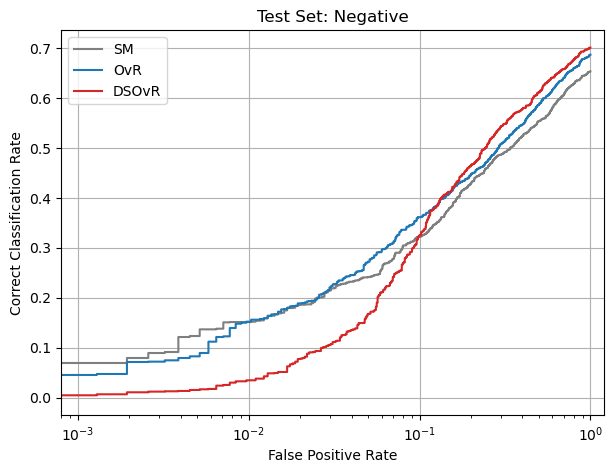

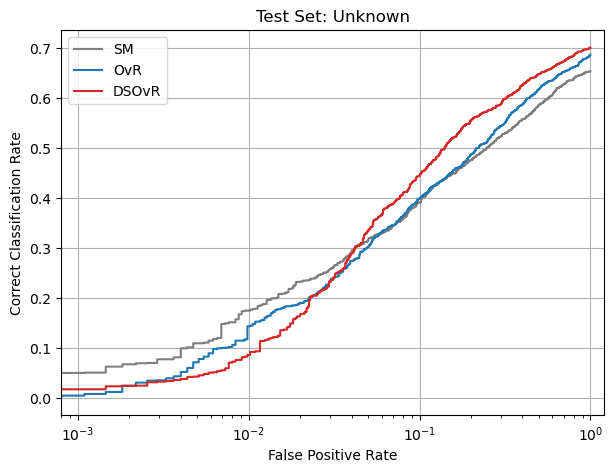

In [379]:
colors = [CMAP_t10[7],CMAP_t10[0],CMAP_t10[3]]
evals.plot_OSCR(data_info, colors, figsize=(7,5), show_val=False)

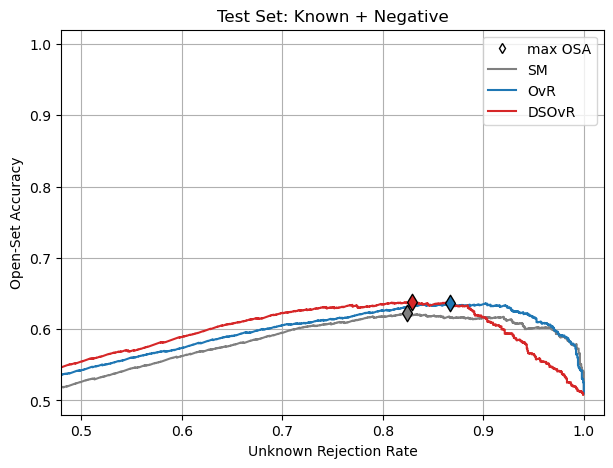

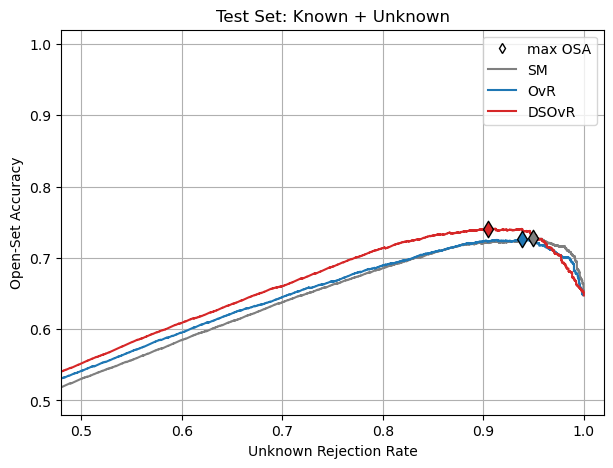

In [380]:
colors = [CMAP_t10[7],CMAP_t10[0],CMAP_t10[3]]
evals.plot_OSAC(data_info, colors, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

#### Protocol 3

In [381]:
PROTOCOL = 3

In [382]:
data_info = sm_data_info_1[PROTOCOL-1] + ovr_data_info_1[PROTOCOL-1] + dsovr_data_info_1[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']


In [383]:
results = evals.print_metrics(data_info, has_neg=False)

FPR↓	FNR↓	maxOSA_U↑
0.0036	0.2310	0.7266
0.0022	0.2766	0.7314
0.0024	0.2397	0.7217


[16.50331126  1.36423841  0.95364238  0.91390728] [69.41721854  2.18543046  1.66887417  1.05960265]
[20.71523179  1.82781457  1.08609272  0.63576159] [71.82781457  4.31788079  2.43708609  1.8807947 ]
[15.89403974  1.78807947  1.16556291  0.83443709] [70.26490066  4.41059603  2.59602649  1.89403974]


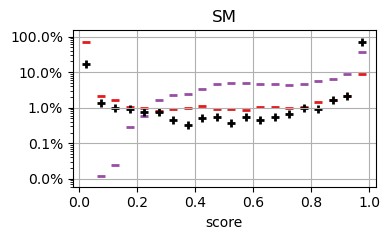

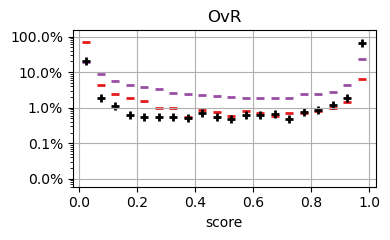

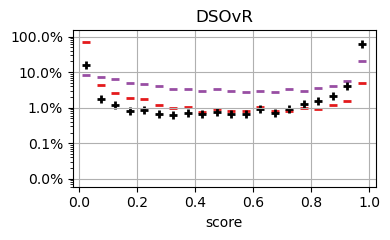

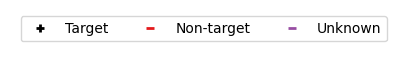

In [384]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

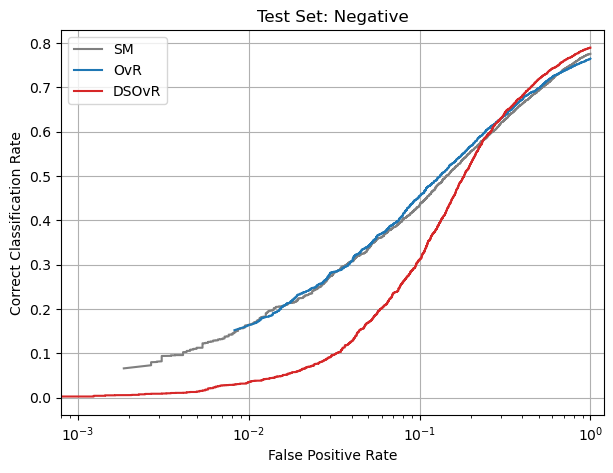

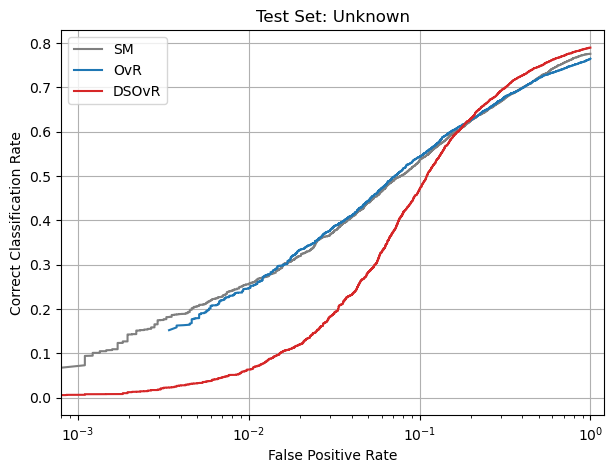

In [385]:
colors = [CMAP_t10[7],CMAP_t10[0],CMAP_t10[3]]
evals.plot_OSCR(data_info, colors, figsize=(7,5), show_val=False)

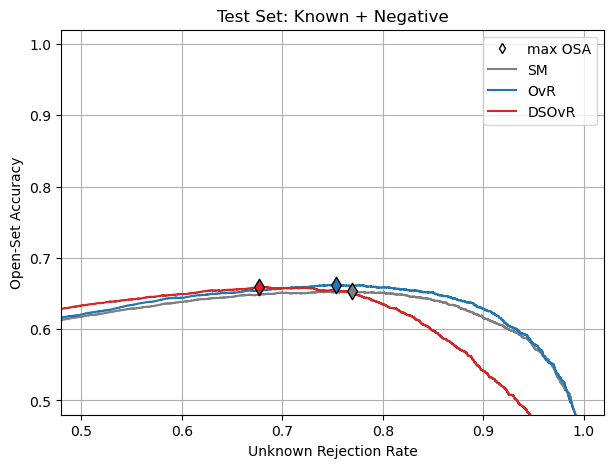

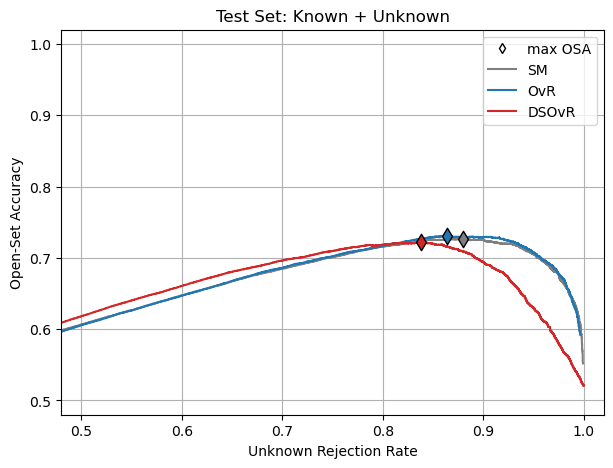

In [386]:
colors = [CMAP_t10[7],CMAP_t10[0],CMAP_t10[3]]
evals.plot_OSAC(data_info, colors, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

### Result 4-2. Loss weighting approaches for data imbalance issue
RQ2. Which loss weighting approach for a set of one-vs-rest classifiers reduces performance imbalance, and how does it impact overall classification performance?

OvR vs. -C vs. -F vs. -M

DSOvR vs. -C vs. -F vs. -M

- Accuracy
- Confusion Matrix with '-1'
- Score distribution
    - Target = P_c
    - Non-Target = max{t is not c}P_t
    - Negative = max{t}P_t
    - Unknown = max{t}P_t
- |FPR-FNR|
- OSCR Curve
- OSA Curve

#### Protocol 1

In [13]:
PROTOCOL = 1

##### OvR

In [14]:
data_info = ovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_M_neg_0_04', 'OvR']


In [15]:
results = evals.print_metrics(data_info, has_neg=False)

FPR↓	FNR↓	maxOSA_U↑
0.0020	0.3460	0.7916
0.1669	0.0729	0.7651
0.0025	0.3859	0.7526
0.0032	0.3095	0.7770


[22.72413793  2.72413793  1.98275862  1.44827586] [57.39655172  6.03448276  4.29310345  2.51724138]
[2.05172414 0.70689655 0.48275862 0.53448276] [0.84482759 0.5862069  0.29310345 0.39655172]
[12.51724138  5.03448276  3.79310345  2.89655172] [22.5862069  11.15517241  8.65517241  7.25862069]
[13.86206897  3.5862069   2.29310345  2.20689655] [26.63793103  8.56896552  6.25862069  4.86206897]


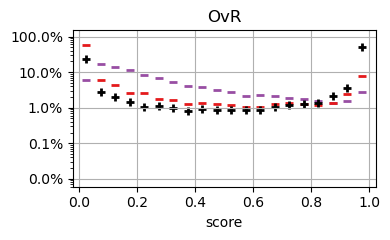

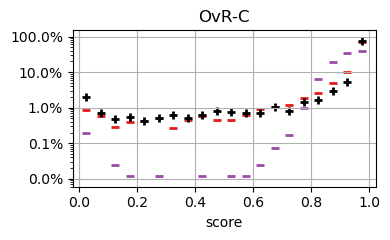

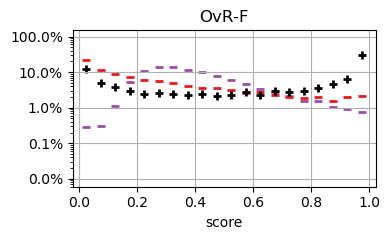

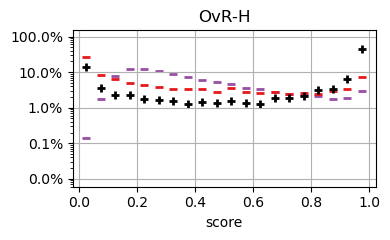

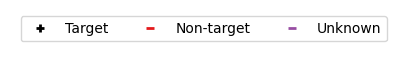

In [17]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

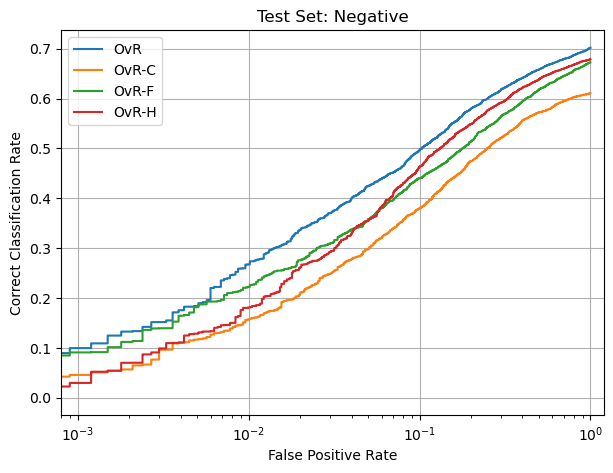

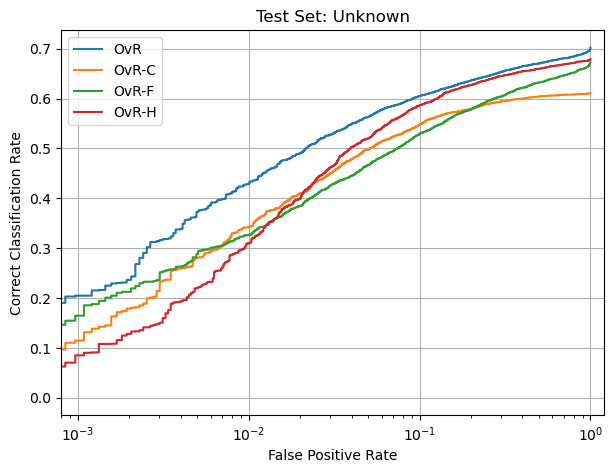

In [19]:
colors = CMAP_t10
evals.plot_OSCR(data_info, colors, figsize=(7,5), show_val=False)

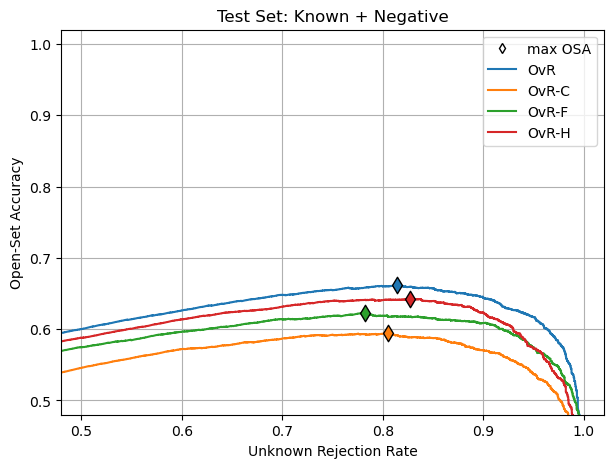

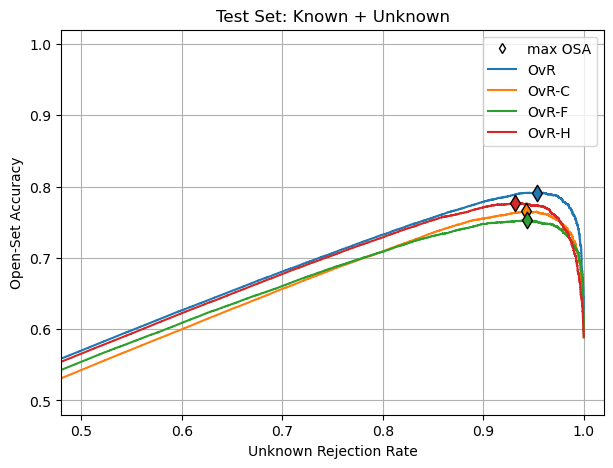

In [20]:
colors = CMAP_t10
evals.plot_OSAC(data_info, colors, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

##### DSOvR

In [21]:
data_info = dsovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']
['LargeScale_1', '_RQ2', 'ResNet_50_C_neg_0_g', 'OpenSetOvR']
['LargeScale_1', '_RQ2', 'ResNet_50_F_neg_0_1', 'OpenSetOvR']
['LargeScale_1', '_RQ2', 'ResNet_50_M_neg_0_04', 'OpenSetOvR']


In [23]:
results = evals.print_metrics(data_info, has_neg=False)

FPR↓	FNR↓	maxOSA_U↑
0.0020	0.3378	0.7784
0.1797	0.0593	0.7593
0.0028	0.3834	0.7571
0.0042	0.2752	0.7765


[18.44827586  3.32758621  2.10344828  1.74137931] [49.60344828  7.79310345  5.53448276  3.5862069 ]
[1.46551724 0.5        0.55172414 0.70689655] [1.43103448 0.82758621 0.4137931  0.5       ]
[15.70689655  4.56896552  3.56896552  2.43103448] [34.39655172 10.17241379  7.51724138  6.4137931 ]
[13.27586207  2.67241379  2.15517241  1.51724138] [28.27586207  7.03448276  4.60344828  3.74137931]


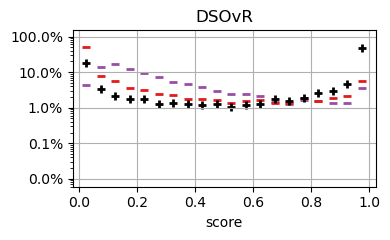

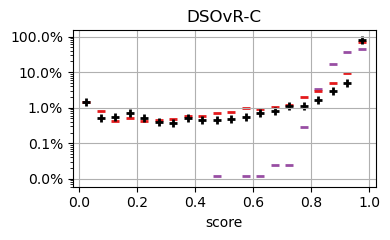

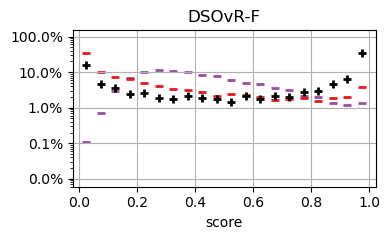

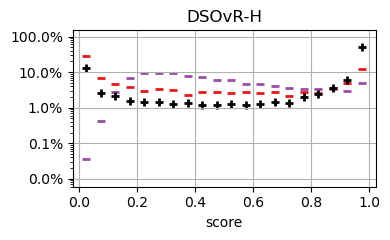

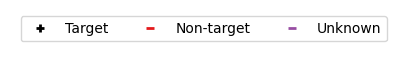

In [24]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

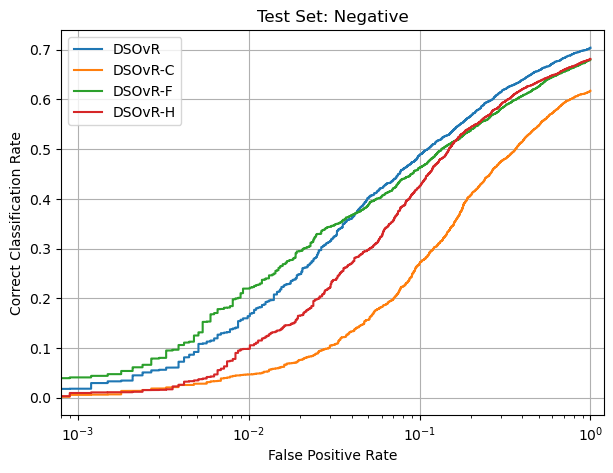

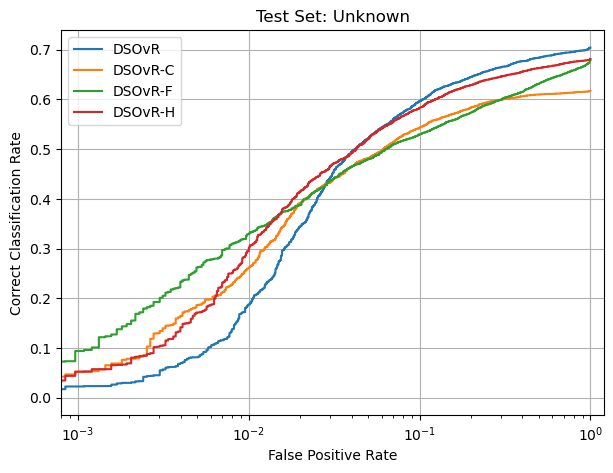

In [244]:
evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)

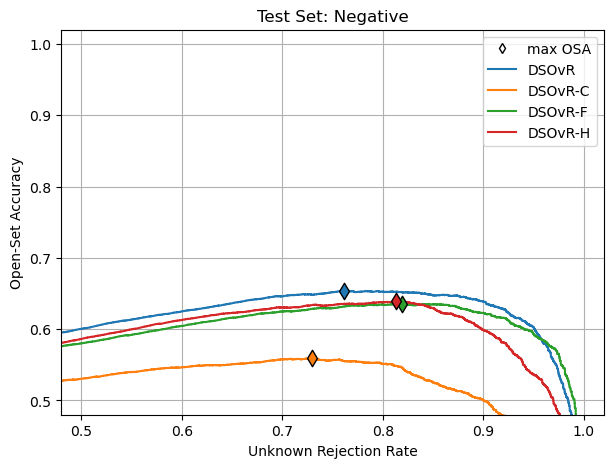

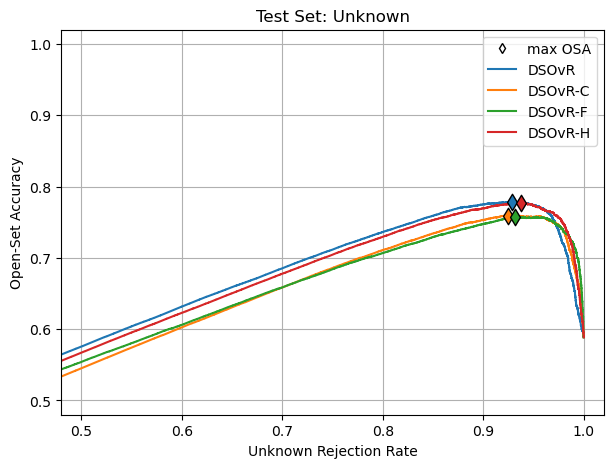

In [245]:
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

#### Protocol 2

In [389]:
PROTOCOL = 2

##### OvR

In [247]:
data_info = ovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_M_neg_0_04', 'OvR']


In [248]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	ACC↑	CCR_N^(0.1)↑	maxOSA_N↑	CCR_U^(0.1)↑	maxOSA_U↑
0.0153	0.3620	0.6867	0.3613	0.6364	0.3993	0.7259
0.1242	0.1320	0.6200	0.2840	0.6007	0.3287	0.7066
0.0152	0.3700	0.6820	0.3660	0.6377	0.4227	0.7362
0.0192	0.3820	0.6300	0.3300	0.6200	0.3853	0.7273


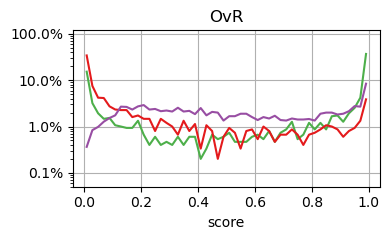

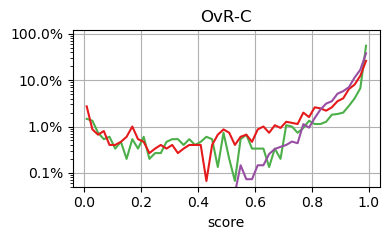

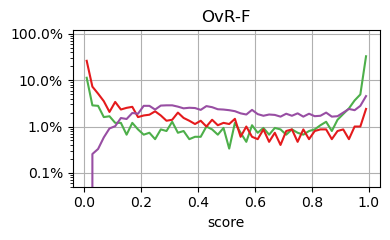

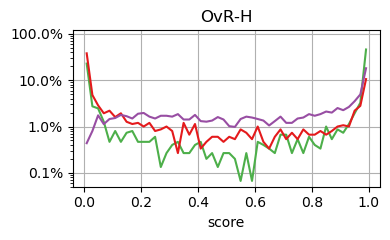

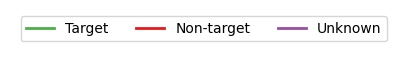

In [249]:
start, stop, step = 0, 1, 0.02
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(5e-2,120), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label=labels[0]),
                  Line2D([0], [0], color=colors[1], lw=2, label=labels[1]),
                  Line2D([0], [0], color=colors[3], lw=2, label=labels[3]),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

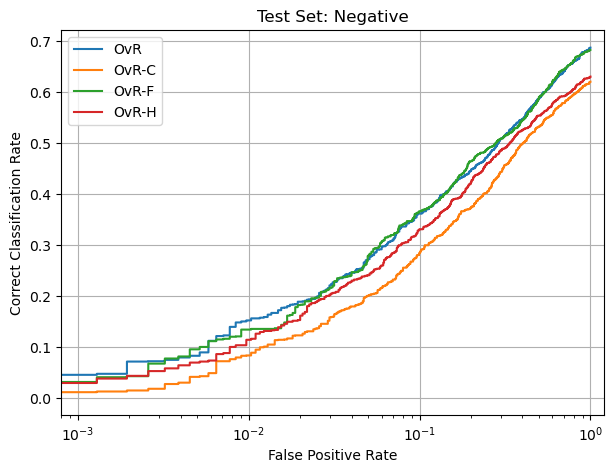

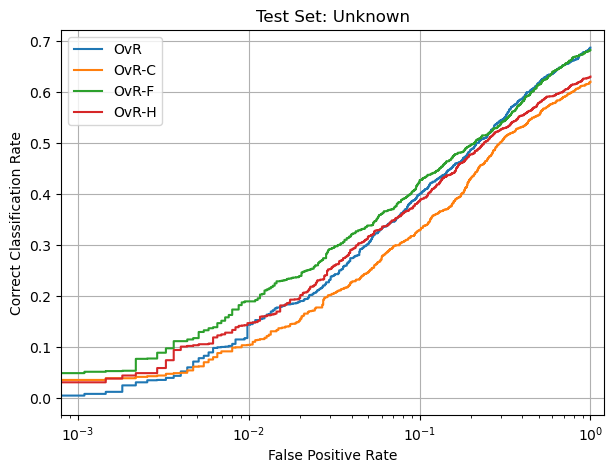

In [250]:
evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)

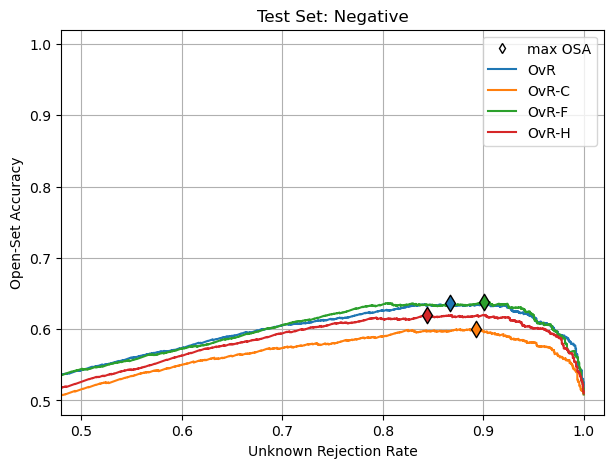

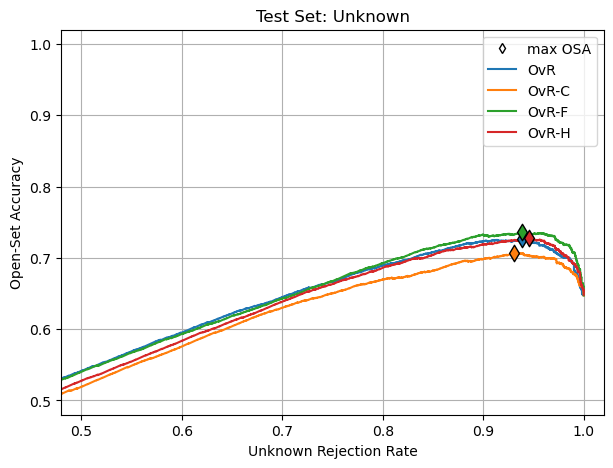

In [251]:
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

##### DSOvR

In [252]:
data_info = dsovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']
['LargeScale_2', '_RQ2', 'ResNet_50_C_neg_0_g', 'OpenSetOvR']
['LargeScale_2', '_RQ2', 'ResNet_50_F_neg_0_1', 'OpenSetOvR']
['LargeScale_2', '_RQ2', 'ResNet_50_M_neg_0_04', 'OpenSetOvR']


In [253]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	ACC↑	CCR_N^(0.1)↑	maxOSA_N↑	CCR_U^(0.1)↑	maxOSA_U↑
0.0176	0.3240	0.7007	0.3240	0.6384	0.4433	0.7409
0.1437	0.1200	0.5773	0.2260	0.5757	0.2993	0.6948
0.0162	0.3113	0.7093	0.3933	0.6603	0.4653	0.7508
0.0195	0.3847	0.6440	0.2860	0.6092	0.3427	0.7047


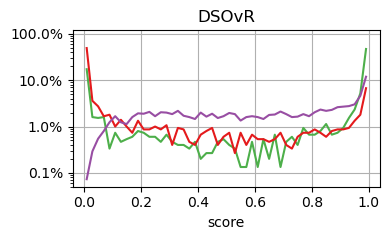

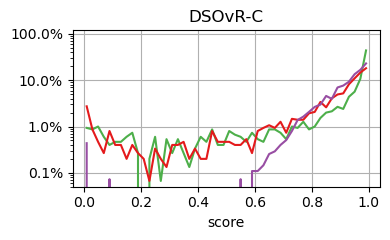

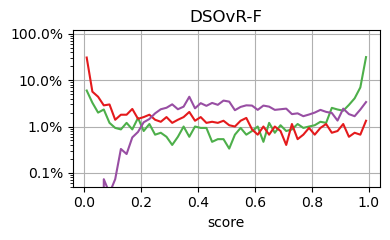

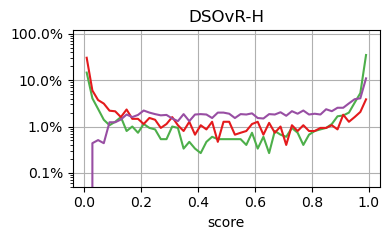

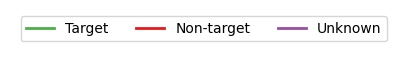

In [254]:
start, stop, step = 0, 1, 0.02
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(5e-2,120), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label=labels[0]),
                  Line2D([0], [0], color=colors[1], lw=2, label=labels[1]),
                  Line2D([0], [0], color=colors[3], lw=2, label=labels[3]),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

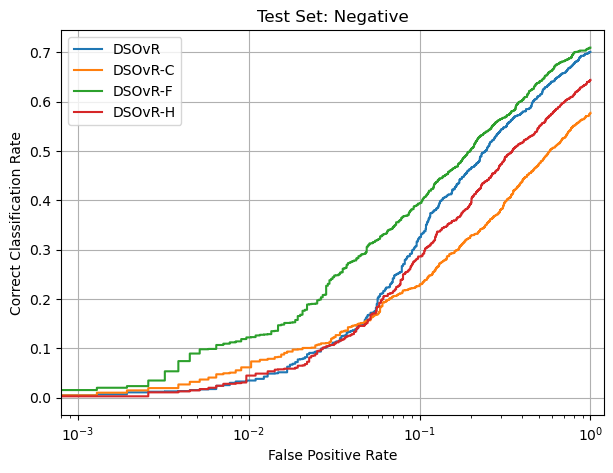

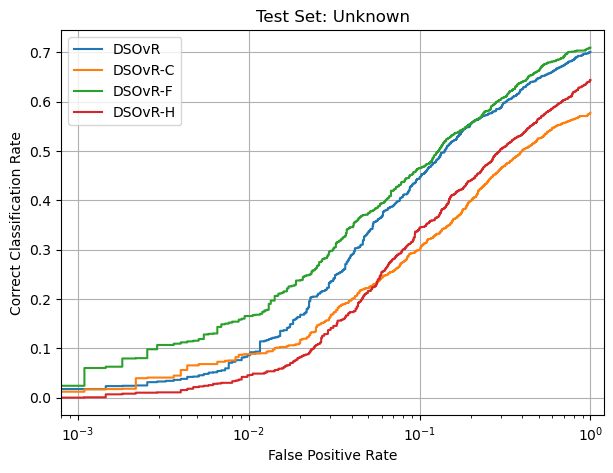

In [255]:
evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)

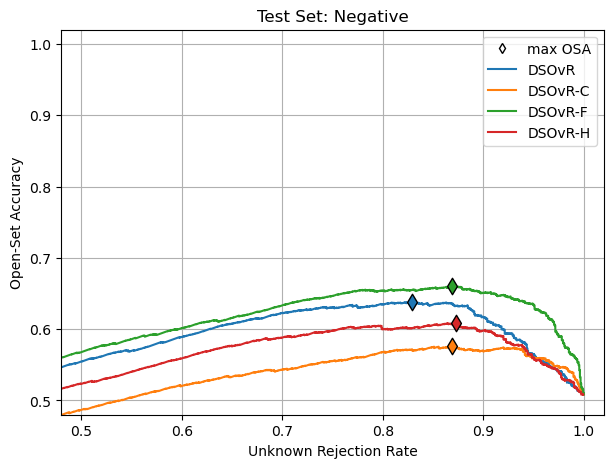

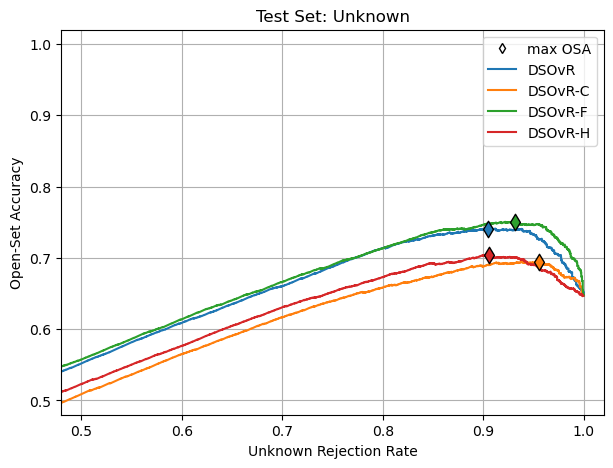

In [256]:
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

#### Protocol 3

In [257]:
PROTOCOL = 3

##### OvR

In [258]:
data_info = ovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_M_neg_0_04', 'OvR']


In [259]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	ACC↑	CCR_N^(0.1)↑	maxOSA_N↑	CCR_U^(0.1)↑	maxOSA_U↑


0.0022	0.2766	0.7645	0.4543	0.6623	0.5429	0.7314
0.0710	0.0347	0.6574	0.2776	0.5473	0.3419	0.6342
0.0020	0.2764	0.7751	0.4501	0.6687	0.5546	0.7367
0.0050	0.1784	0.7811	0.4502	0.6669	0.5661	0.7423


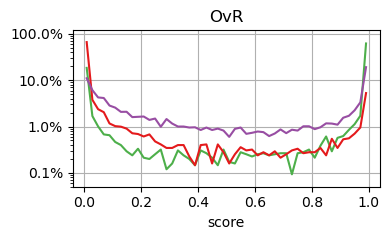

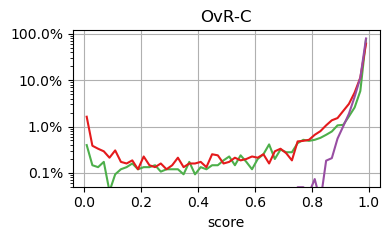

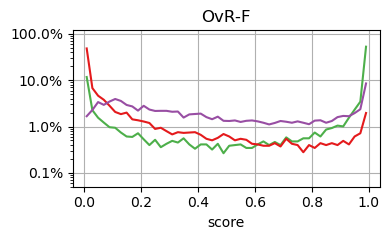

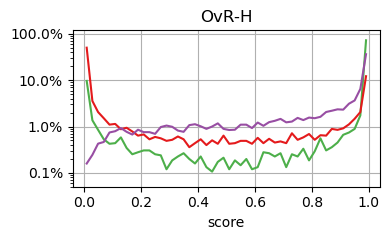

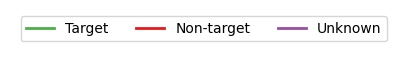

In [260]:
start, stop, step = 0, 1, 0.02
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(5e-2,120), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label=labels[0]),
                  Line2D([0], [0], color=colors[1], lw=2, label=labels[1]),
                  Line2D([0], [0], color=colors[3], lw=2, label=labels[3]),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

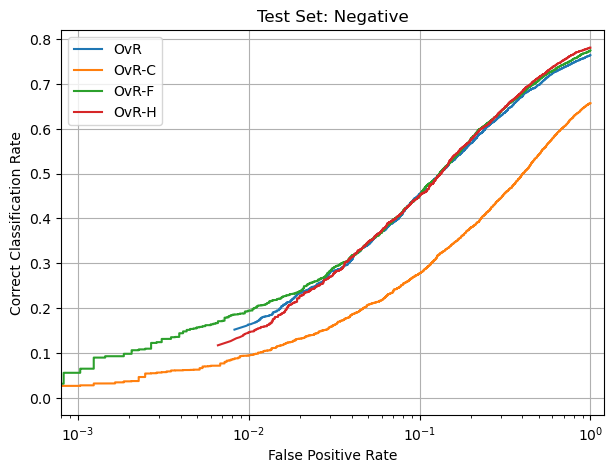

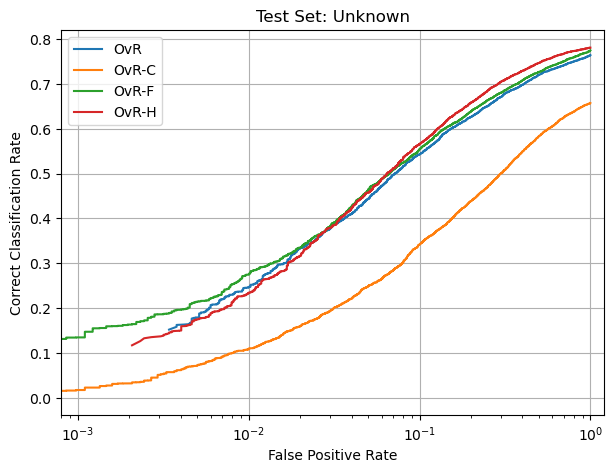

In [261]:
evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)

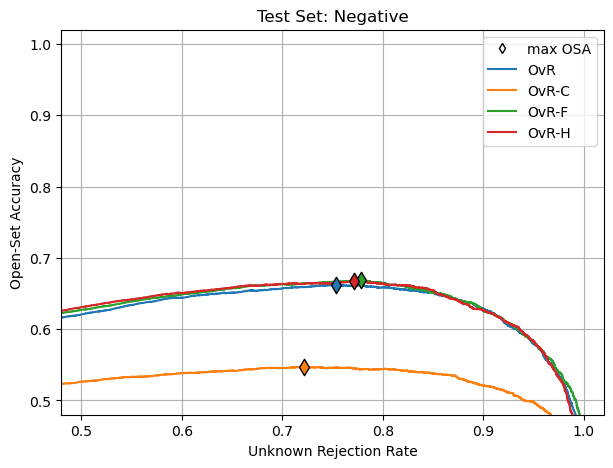

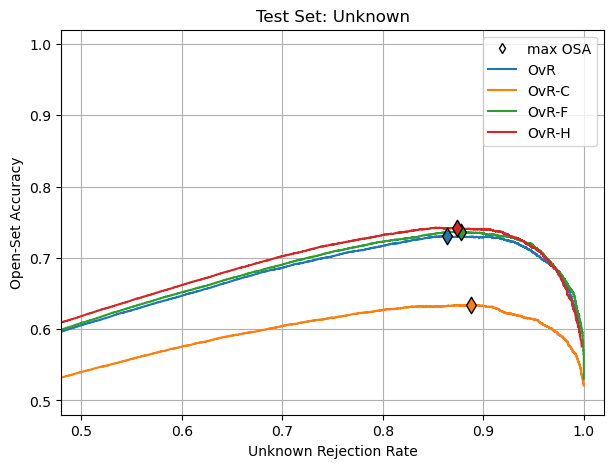

In [262]:
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

##### DSOvR

In [263]:
data_info = dsovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']
['LargeScale_3', '_RQ2', 'ResNet_50_C_neg_0_g', 'OpenSetOvR']
['LargeScale_3', '_RQ2', 'ResNet_50_F_neg_0_1', 'OpenSetOvR']
['LargeScale_3', '_RQ2', 'ResNet_50_M_neg_0_04', 'OpenSetOvR']


In [264]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	ACC↑	CCR_N^(0.1)↑	maxOSA_N↑	CCR_U^(0.1)↑	maxOSA_U↑


0.0024	0.2397	0.7893	0.3113	0.6592	0.4695	0.7217
0.0468	0.0491	0.6848	0.1486	0.5179	0.2062	0.5929
0.0031	0.2335	0.7788	0.3970	0.6597	0.5298	0.7257
0.0057	0.2030	0.7666	0.1878	0.5627	0.3311	0.6486


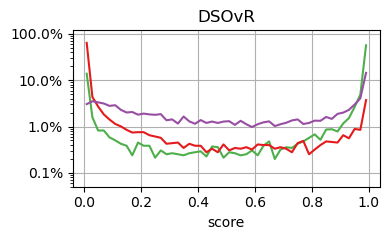

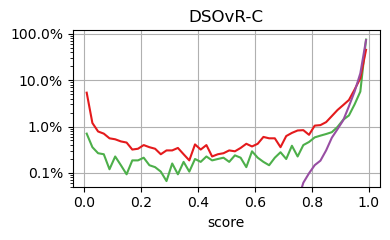

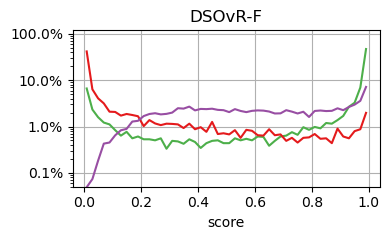

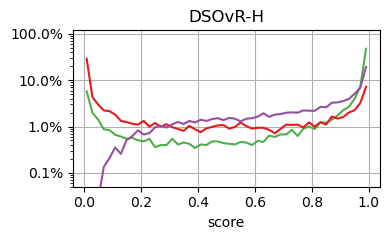

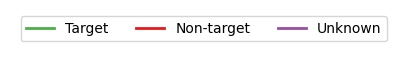

In [265]:
start, stop, step = 0, 1, 0.02
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(5e-2,120), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label=labels[0]),
                  Line2D([0], [0], color=colors[1], lw=2, label=labels[1]),
                  Line2D([0], [0], color=colors[3], lw=2, label=labels[3]),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

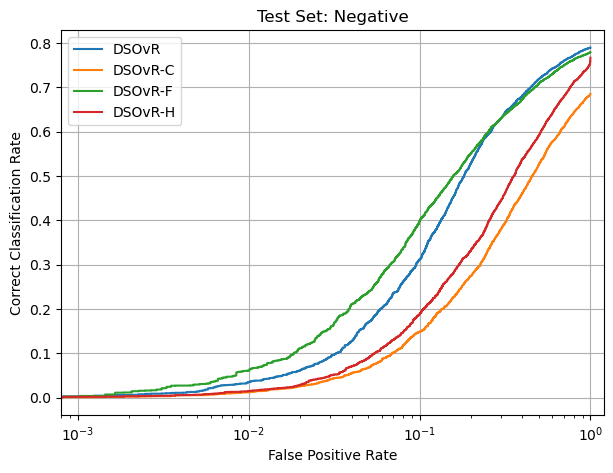

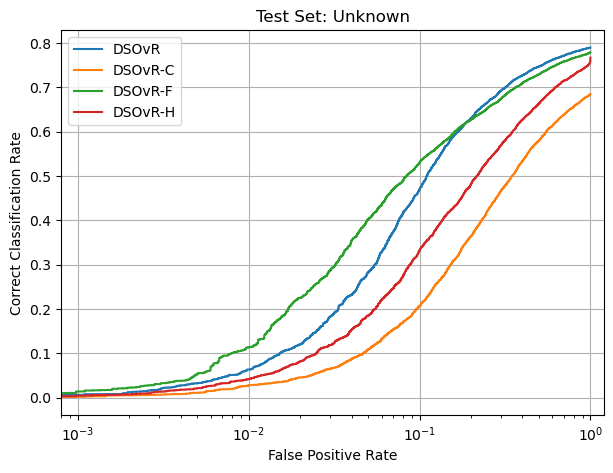

In [266]:
evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)

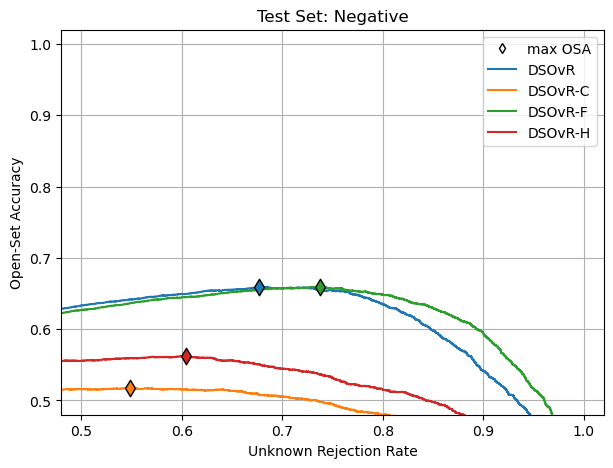

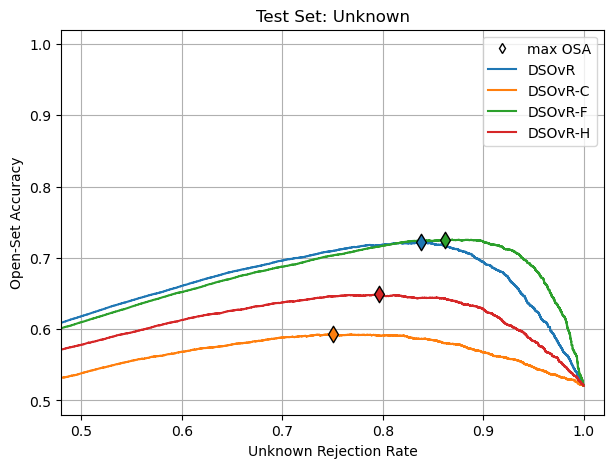

In [267]:
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

#### Highlight

##### Protocol 2

In [433]:
PROTOCOL = 2

In [434]:
data_info = sm_data_info_1[PROTOCOL-1] + dsovr_data_info_2[PROTOCOL-1][0:1] + dsovr_data_info_2[PROTOCOL-1][2:3]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']
['LargeScale_2', '_RQ2', 'ResNet_50_F_neg_0_1', 'OpenSetOvR']


In [435]:
results = evals.print_metrics(data_info, has_neg=False)

FPR↓	FNR↓	maxOSA_U↑
0.0209	0.3620	0.7273
0.0176	0.3240	0.7409
0.0162	0.3113	0.7508


[20.73333333  3.53333333  2.53333333  1.86666667] [50.86666667  3.73333333  2.6         1.93333333]
[19.73333333  2.66666667  1.6         1.53333333] [55.06666667  4.4         2.73333333  2.73333333]
[10.73333333  4.06666667  2.33333333  3.06666667] [39.06666667  7.86666667  4.33333333  4.53333333]


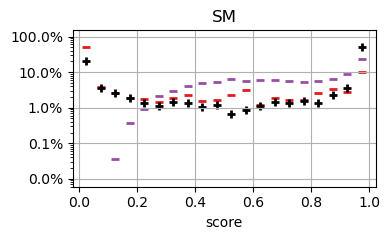

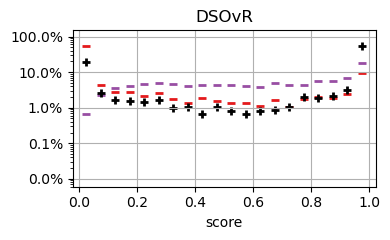

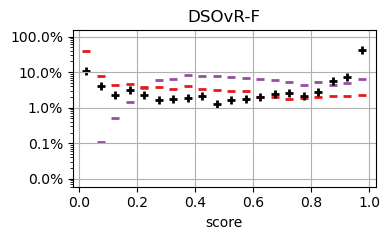

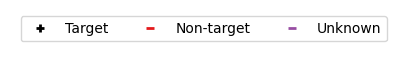

In [436]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

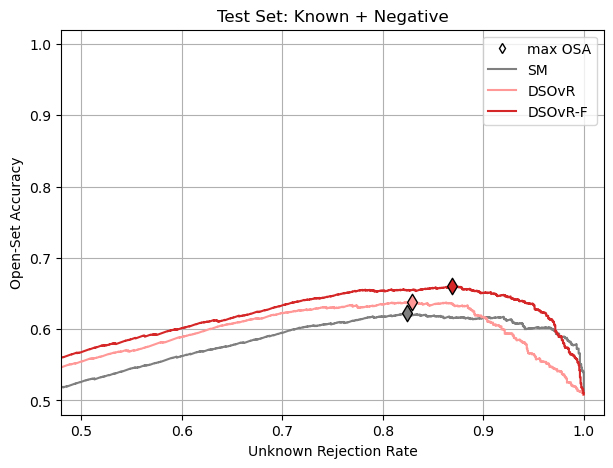

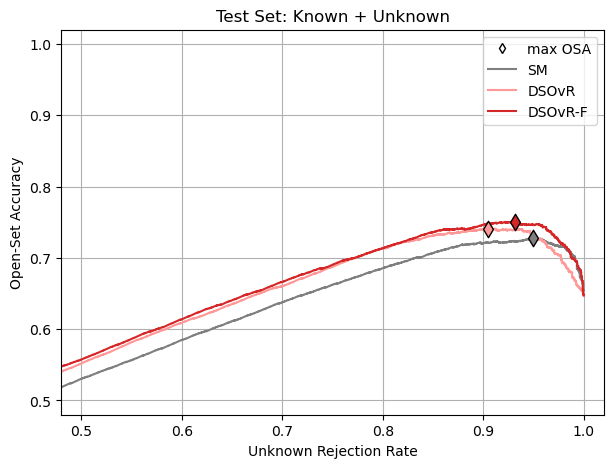

In [438]:
colors = [CMAP_t10[7]]+[CMAP_t20[7],CMAP_t20[6]]
evals.plot_OSAC(data_info, colors, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

##### Protocol 3

In [447]:
PROTOCOL = 3

In [449]:
data_info = sm_data_info_1[PROTOCOL-1] + ovr_data_info_2[PROTOCOL-1][0:1] + ovr_data_info_2[PROTOCOL-1][3:] + dsovr_data_info_2[PROTOCOL-1][0:1] + dsovr_data_info_2[PROTOCOL-1][2:3]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_M_neg_0_04', 'OvR']
['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']
['LargeScale_3', '_RQ2', 'ResNet_50_F_neg_0_1', 'OpenSetOvR']


In [450]:
results = evals.print_metrics(data_info, has_neg=False)

FPR↓	FNR↓	maxOSA_U↑
0.0036	0.2310	0.7266
0.0022	0.2766	0.7314
0.0050	0.1784	0.7423
0.0024	0.2397	0.7217
0.0031	0.2335	0.7257


[16.50331126  1.36423841  0.95364238  0.91390728] [69.41721854  2.18543046  1.66887417  1.05960265]
[20.71523179  1.82781457  1.08609272  0.63576159] [71.82781457  4.31788079  2.43708609  1.8807947 ]
[11.56291391  1.28476821  1.20529801  0.68874172] [55.25827815  3.58940397  2.49006623  1.8807947 ]
[15.89403974  1.78807947  1.16556291  0.83443709] [70.26490066  4.41059603  2.59602649  1.89403974]
[9.7615894  3.13907285 1.94701987 1.45695364] [50.63576159  7.05960265  4.71523179  4.38410596]


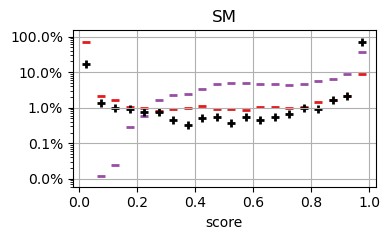

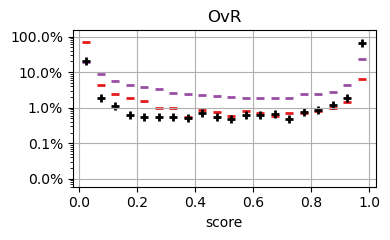

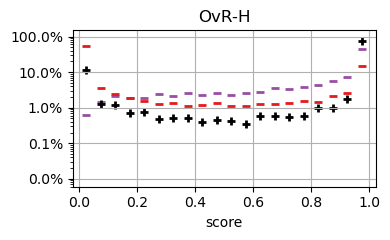

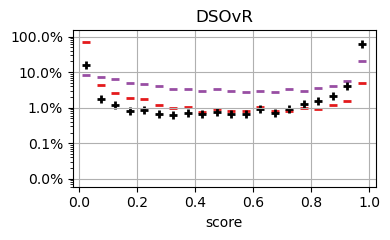

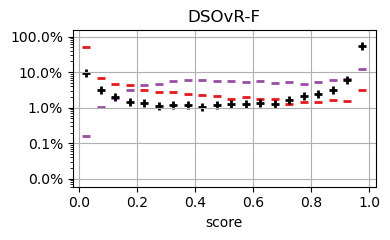

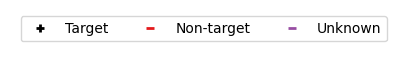

In [451]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

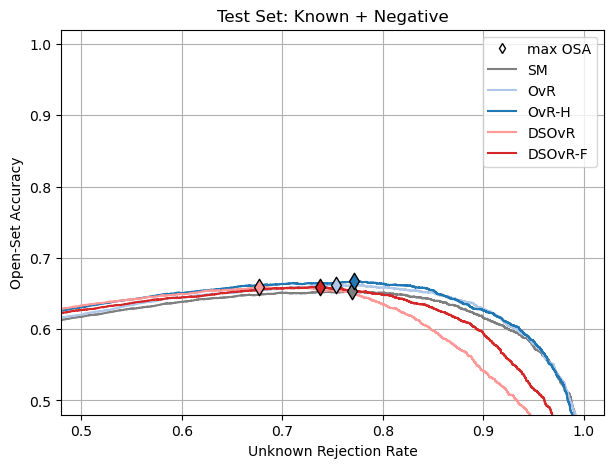

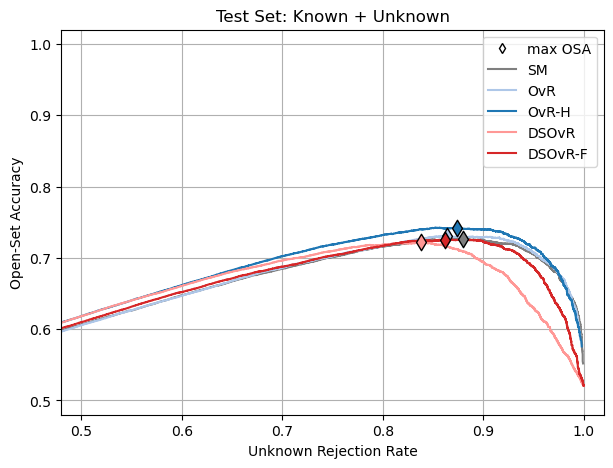

In [454]:
colors = [CMAP_t10[7]]+ [CMAP_t20[1],CMAP_t20[0]] + [CMAP_t20[7],CMAP_t20[6]]
evals.plot_OSAC(data_info, colors, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

### Result 4-3.Including negatives in training 

RQ3. Does including negative samples in training improve open-set classification performance, and can loss weighting approaches mitigate the negative effects of increased dataset imbalance?

.
- OvR vs. OvR (- 10k) vs. OvR (- 20k) vs. OvR (- 30k) vs. OvR (- All) 
- OvR-C vs. OvR-C (- 10k) vs. OvR-C (- 20k) vs. OvR-C (- 30k) vs. OvR-C (- All) 
- OvR-F vs. OvR-F (- 10k) vs. OvR-F (- 20k) vs. OvR-F (- 30k) vs. OvR-F (- All) 
- OvR-H vs. OvR-H (- 10k) vs. OvR-H (- 20k) vs. OvR-H (- 30k) vs. OvR-H (- All) 

.
- DSOvR vs. DSOvR (- 10k) vs. DSOvR (- 20k) vs. DSOvR (- 30k) vs. DSOvR (- All) 
- DSOvR-C vs. DSOvR-C (- 10k) vs. DSOvR-C (- 20k) vs. DSOvR-C (- 30k) vs. DSOvR-C (- All) 
- DSOvR-F vs. DSOvR-F (- 10k) vs. DSOvR-F (- 20k) vs. DSOvR-F (- 30k) vs. DSOvR-F (- All) 
- DSOvR-H vs. DSOvR-H (- 10k) vs. DSOvR-H (- 20k) vs. DSOvR-H (- 30k) vs. DSOvR-H (- All) 

.
- Accuracy
- Confusion Matrix with '-1'
- Score distribution
    - Target = P_c
    - Non-Target = max{t is not c}P_t
    - Negative = max{t}P_t
    - Unknown = max{t}P_t
- |FPR-FNR|
- OSCR Curve
- OSA Curve


#### Protocol 1

In [458]:
PROTOCOL = 1

##### OvR

In [459]:
data_info = ovr_data_info_2[PROTOCOL-1][:1] + ovr_data_info_3[PROTOCOL-1][:1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_neg_All', 'OvR']


In [460]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0020	0.3460	0.6613	0.7916
0.0012	0.3743	0.7758	0.7947


In [461]:
data_info = ovr_data_info_2[PROTOCOL-1][1:2] + ovr_data_info_3[PROTOCOL-1][1:2]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_C_neg_All_g', 'OvR']


In [462]:
results_c = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.1669	0.0729	0.5945	0.7651
0.0643	0.1076	0.7484	0.7711


In [463]:
data_info = ovr_data_info_2[PROTOCOL-1][2:3] + ovr_data_info_3[PROTOCOL-1][2:3]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']


In [464]:
results_f = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.0025	0.3859	0.6226	0.7526
0.0021	0.3976	0.7489	0.7682


In [465]:
data_info = ovr_data_info_2[PROTOCOL-1][3:] + ovr_data_info_3[PROTOCOL-1][3:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ2', 'ResNet_50_M_neg_0_04', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_M_neg_All_06', 'OvR']


In [466]:
results_h = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.0032	0.3095	0.6423	0.7770
0.0028	0.2836	0.7748	0.8061


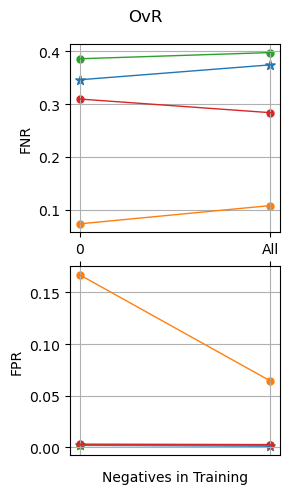

In [473]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0,0.42),(0,0.17)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['fnr_avg'] for r in res['res_fpr_fnr']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['fnr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)
    axs[1].plot([r['fpr_avg'] for r in res['res_fpr_fnr']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['fpr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)

axs[0].set_ylabel('FNR')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('FPR')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('OvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

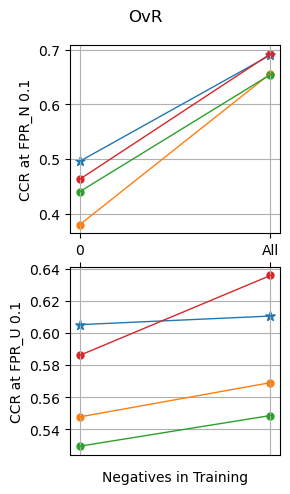

In [474]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0.3,0.75),(0.5,0.65)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['negative'] for r in res['oscr']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['negative'] for r in res['oscr']], marker=marker, s=size)
    axs[1].plot([r['unknown'] for r in res['oscr']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['unknown'] for r in res['oscr']], marker=marker, s=size)

axs[0].set_ylabel('CCR at FPR_N 0.1')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('CCR at FPR_U 0.1')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('OvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

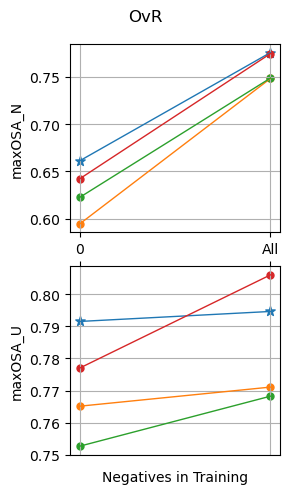

In [475]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0.55,0.8),(0.75,0.81)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['iosa_neg'] for r in res['oosa']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['iosa_neg'] for r in res['oosa']], marker=marker, s=size)
    axs[1].plot([r['iosa_unkn'] for r in res['oosa']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['iosa_unkn'] for r in res['oosa']], marker=marker, s=size)

axs[0].set_ylabel('maxOSA_N')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('maxOSA_U')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('OvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

##### DSOvR

In [476]:
data_info = dsovr_data_info_2[PROTOCOL-1][:1] + dsovr_data_info_3[PROTOCOL-1][:1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_neg_All', 'OpenSetOvR']


In [477]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0020	0.3378	0.6537	0.7784
0.0010	0.3741	0.7894	0.8036


In [478]:
data_info = dsovr_data_info_2[PROTOCOL-1][1:2] + dsovr_data_info_3[PROTOCOL-1][1:2]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ2', 'ResNet_50_C_neg_0_g', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_C_neg_All_b', 'OpenSetOvR']


In [479]:
results_c = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.1797	0.0593	0.5591	0.7593
0.0400	0.1098	0.7460	0.7467


In [480]:
data_info = dsovr_data_info_2[PROTOCOL-1][2:3] + dsovr_data_info_3[PROTOCOL-1][2:3]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ2', 'ResNet_50_F_neg_0_1', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_F_neg_All_1', 'OpenSetOvR']


In [481]:
results_f = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.0028	0.3834	0.6355	0.7571
0.0016	0.3512	0.7861	0.7932


In [482]:
data_info = dsovr_data_info_2[PROTOCOL-1][3:] + dsovr_data_info_3[PROTOCOL-1][3:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ2', 'ResNet_50_M_neg_0_04', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_M_neg_All_06', 'OpenSetOvR']


In [483]:
results_h = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.0042	0.2752	0.6391	0.7765
0.0048	0.2269	0.7634	0.7856


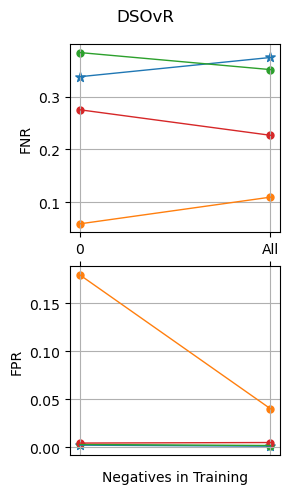

In [487]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0,0.42),(0,0.17)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['fnr_avg'] for r in res['res_fpr_fnr']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['fnr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)
    axs[1].plot([r['fpr_avg'] for r in res['res_fpr_fnr']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['fpr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)

axs[0].set_ylabel('FNR')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('FPR')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('DSOvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

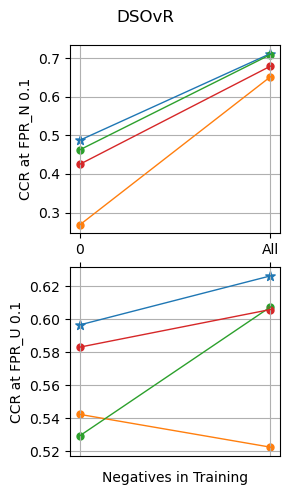

In [488]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0.3,0.75),(0.5,0.65)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['negative'] for r in res['oscr']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['negative'] for r in res['oscr']], marker=marker, s=size)
    axs[1].plot([r['unknown'] for r in res['oscr']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['unknown'] for r in res['oscr']], marker=marker, s=size)

axs[0].set_ylabel('CCR at FPR_N 0.1')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('CCR at FPR_U 0.1')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('DSOvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

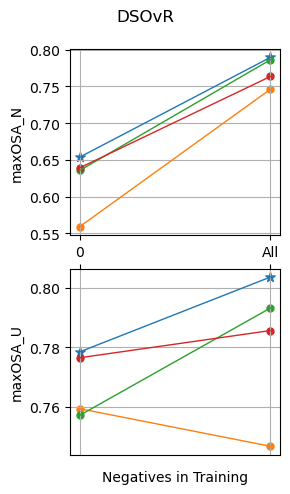

In [489]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0.55,0.8),(0.75,0.81)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['iosa_neg'] for r in res['oosa']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['iosa_neg'] for r in res['oosa']], marker=marker, s=size)
    axs[1].plot([r['iosa_unkn'] for r in res['oosa']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['iosa_unkn'] for r in res['oosa']], marker=marker, s=size)

axs[0].set_ylabel('maxOSA_N')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('maxOSA_U')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('DSOvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

##### Overall
- Negatives in training
- EOS vs. OvR vs. OvR-H vs. DSOvR

In [513]:
data_info = eos_data_info_3[PROTOCOL-1][-1:] + ovr_data_info_3[PROTOCOL-1][0:1] + ovr_data_info_3[PROTOCOL-1][3:] + dsovr_data_info_3[PROTOCOL-1][0:1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ3', 'ResNet_50_neg_All', 'EOS']
['LargeScale_1', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_M_neg_All_06', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_neg_All', 'OpenSetOvR']


In [514]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0013	0.3410	0.7835	0.8184
0.0012	0.3743	0.7758	0.7947
0.0028	0.2836	0.7748	0.8061
0.0010	0.3741	0.7894	0.8036


[21.55172414  2.94827586  1.62068966  1.5       ] [54.32758621  4.17241379  3.06896552  2.44827586]


[25.94827586  2.9137931   1.5         1.4137931 ] [64.75862069  5.48275862  3.34482759  2.27586207]
[13.94827586  3.05172414  1.75862069  1.74137931] [29.25862069  8.22413793  5.67241379  4.55172414]
[24.43103448  2.75862069  2.24137931  1.36206897] [65.44827586  5.74137931  3.79310345  2.56896552]


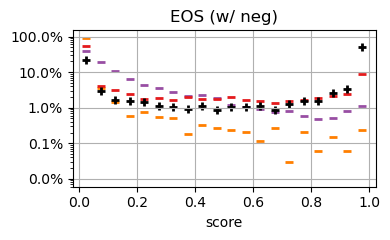

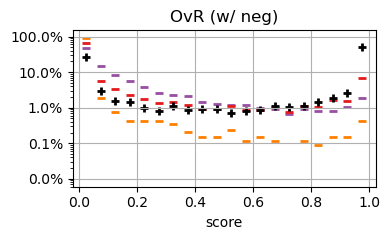

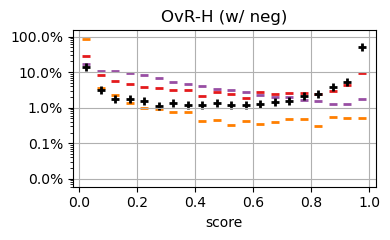

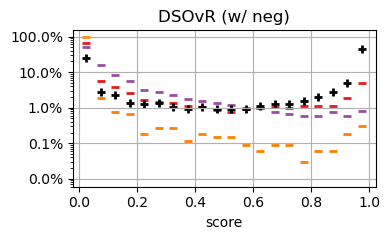

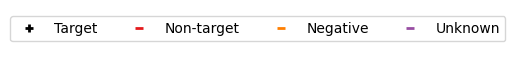

In [515]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[4],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=True)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[2], lw=0, label=labels[2], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

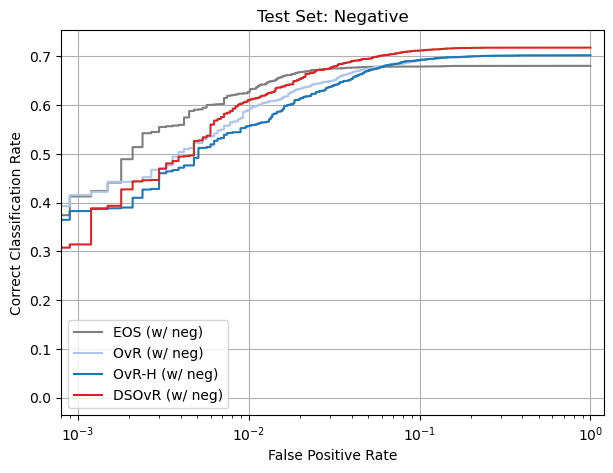

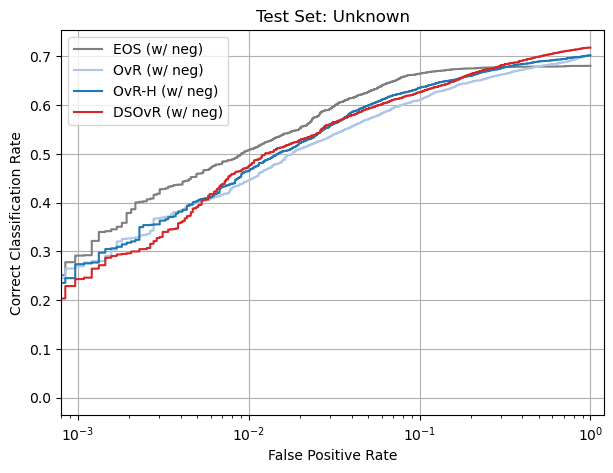

In [516]:
colors = [CMAP_t10[7]]+ [CMAP_t20[1],CMAP_t20[0]] + [CMAP_t20[6]]
evals.plot_OSCR(data_info, colors, figsize=(7,5), show_val=False)

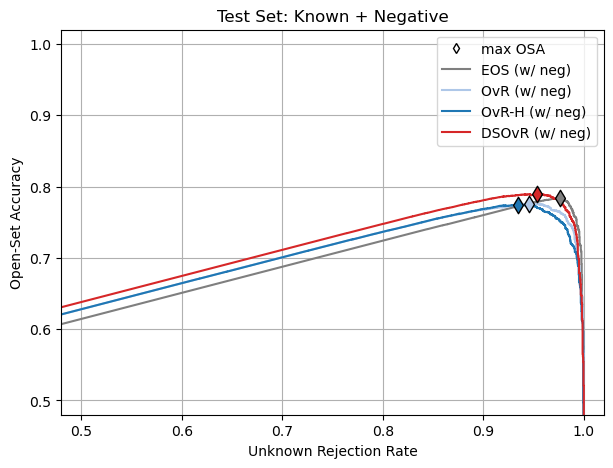

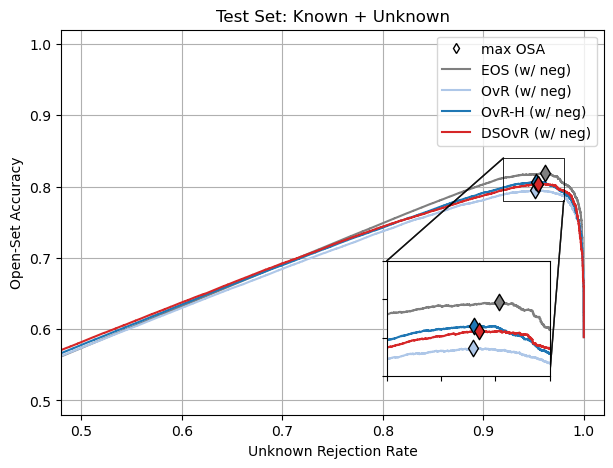

In [520]:
colors = [CMAP_t10[7]]+ [CMAP_t20[1],CMAP_t20[0]] + [CMAP_t20[6]]
evals.plot_OSAC(data_info, colors, figsize=(7,5),
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True),
                zoom=((False,(0,0,0,0),(0,0,0,0)),(True,(0.92,0.98,0.78,0.84),(0.6,0.1,0.3,0.3))))

#### Protocol 2

In [521]:
PROTOCOL = 2

##### OvR

In [522]:
data_info = ovr_data_info_2[PROTOCOL-1][:1] + ovr_data_info_3[PROTOCOL-1][:1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'OvR']


In [523]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0153	0.3620	0.6364	0.7259
0.0058	0.4820	0.7325	0.7478


In [524]:
data_info = ovr_data_info_2[PROTOCOL-1][1:2] + ovr_data_info_3[PROTOCOL-1][1:2]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_neg_All_g', 'OvR']


In [525]:
results_c = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.1242	0.1320	0.6007	0.7066
0.0486	0.2100	0.7170	0.7325


In [526]:
data_info = ovr_data_info_2[PROTOCOL-1][2:3] + ovr_data_info_3[PROTOCOL-1][2:3]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']


In [527]:
results_f = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0152	0.3700	0.6377	0.7362
0.0057	0.5080	0.7256	0.7395


In [528]:
data_info = ovr_data_info_2[PROTOCOL-1][3:] + ovr_data_info_3[PROTOCOL-1][3:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ2', 'ResNet_50_M_neg_0_04', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_M_neg_All_06', 'OvR']


In [529]:
results_h = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0192	0.3820	0.6200	0.7273
0.0074	0.4507	0.7341	0.7407


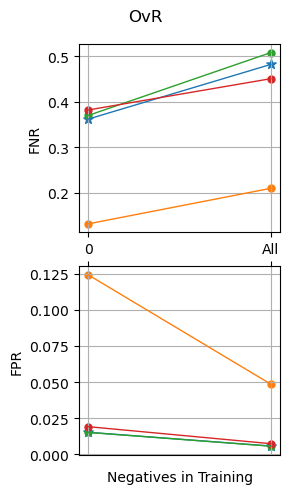

In [531]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0,0.42),(0,0.17)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['fnr_avg'] for r in res['res_fpr_fnr']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['fnr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)
    axs[1].plot([r['fpr_avg'] for r in res['res_fpr_fnr']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['fpr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)

axs[0].set_ylabel('FNR')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('FPR')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('OvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

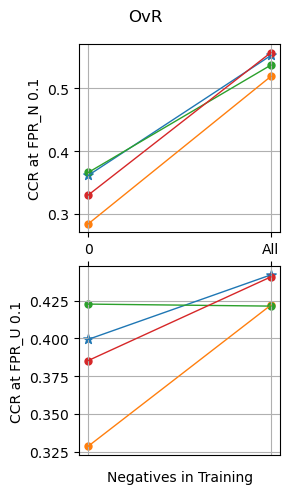

In [532]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0.3,0.75),(0.5,0.65)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['negative'] for r in res['oscr']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['negative'] for r in res['oscr']], marker=marker, s=size)
    axs[1].plot([r['unknown'] for r in res['oscr']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['unknown'] for r in res['oscr']], marker=marker, s=size)

axs[0].set_ylabel('CCR at FPR_N 0.1')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('CCR at FPR_U 0.1')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('OvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

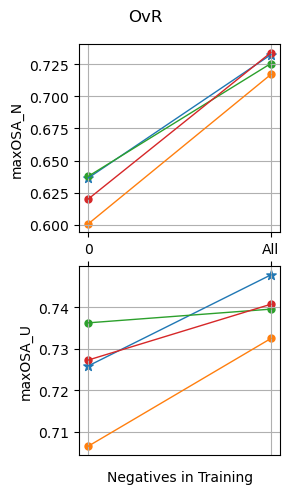

In [533]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0.55,0.8),(0.75,0.81)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['iosa_neg'] for r in res['oosa']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['iosa_neg'] for r in res['oosa']], marker=marker, s=size)
    axs[1].plot([r['iosa_unkn'] for r in res['oosa']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['iosa_unkn'] for r in res['oosa']], marker=marker, s=size)

axs[0].set_ylabel('maxOSA_N')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('maxOSA_U')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('OvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

##### DSOvR

In [534]:
data_info = dsovr_data_info_2[PROTOCOL-1][:1] + dsovr_data_info_3[PROTOCOL-1][:1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'OpenSetOvR']


In [535]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0176	0.3240	0.6384	0.7409
0.0052	0.5253	0.7111	0.7247


In [536]:
data_info = dsovr_data_info_2[PROTOCOL-1][1:2] + dsovr_data_info_3[PROTOCOL-1][1:2]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ2', 'ResNet_50_C_neg_0_g', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_neg_All_b', 'OpenSetOvR']


In [537]:
results_c = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.1437	0.1200	0.5757	0.6948
0.0338	0.2540	0.6961	0.7214


In [538]:
data_info = dsovr_data_info_2[PROTOCOL-1][2:3] + dsovr_data_info_3[PROTOCOL-1][2:3]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ2', 'ResNet_50_F_neg_0_1', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_neg_All_1', 'OpenSetOvR']


In [539]:
results_f = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0162	0.3113	0.6603	0.7508
0.0052	0.4660	0.7479	0.7546


In [540]:
data_info = dsovr_data_info_2[PROTOCOL-1][3:] + dsovr_data_info_3[PROTOCOL-1][3:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ2', 'ResNet_50_M_neg_0_04', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_M_neg_All_06', 'OpenSetOvR']


In [541]:
results_h = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0195	0.3847	0.6092	0.7047
0.0083	0.4280	0.7361	0.7351


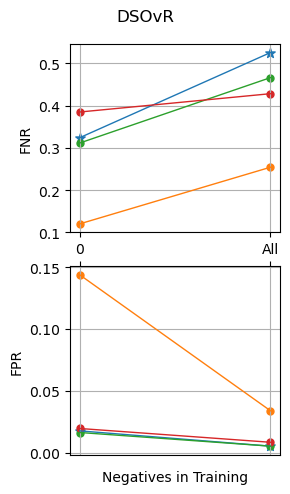

In [543]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0,0.42),(0,0.17)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['fnr_avg'] for r in res['res_fpr_fnr']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['fnr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)
    axs[1].plot([r['fpr_avg'] for r in res['res_fpr_fnr']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['fpr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)

axs[0].set_ylabel('FNR')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('FPR')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('DSOvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

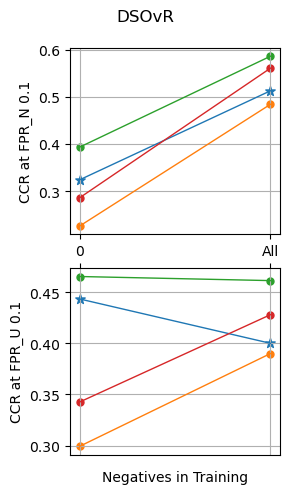

In [544]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0.3,0.75),(0.5,0.65)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['negative'] for r in res['oscr']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['negative'] for r in res['oscr']], marker=marker, s=size)
    axs[1].plot([r['unknown'] for r in res['oscr']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['unknown'] for r in res['oscr']], marker=marker, s=size)

axs[0].set_ylabel('CCR at FPR_N 0.1')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('CCR at FPR_U 0.1')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('DSOvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

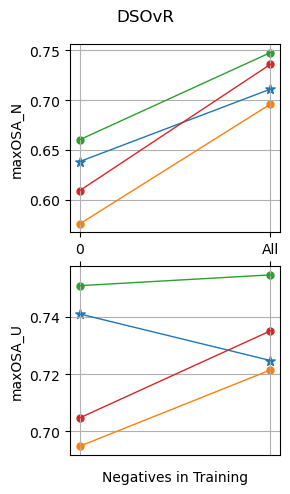

In [545]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0.55,0.8),(0.75,0.81)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['iosa_neg'] for r in res['oosa']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['iosa_neg'] for r in res['oosa']], marker=marker, s=size)
    axs[1].plot([r['iosa_unkn'] for r in res['oosa']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['iosa_unkn'] for r in res['oosa']], marker=marker, s=size)

axs[0].set_ylabel('maxOSA_N')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('maxOSA_U')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('DSOvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

##### Overall
- Negatives in training
- EOS vs. OvR vs. DSOvR vs. DSOvR-F

In [546]:
data_info = eos_data_info_3[PROTOCOL-1][-1:] + ovr_data_info_3[PROTOCOL-1][:1] + dsovr_data_info_3[PROTOCOL-1][:1] + dsovr_data_info_3[PROTOCOL-1][2:3]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'EOS']
['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_neg_All_1', 'OpenSetOvR']


In [547]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0067	0.4513	0.7433	0.7527
0.0058	0.4820	0.7325	0.7478
0.0052	0.5253	0.7111	0.7247
0.0052	0.4660	0.7479	0.7546


[21.73333333  6.          4.2         2.66666667] [48.46666667 13.26666667  5.46666667  4.06666667]
[34.13333333  3.46666667  1.66666667  1.86666667] [67.73333333  5.93333333  3.06666667  1.66666667]
[36.33333333  3.73333333  3.2         1.66666667] [67.66666667  8.          4.2         2.33333333]
[22.46666667  5.4         4.4         3.        ] [52.         12.06666667  6.93333333  4.73333333]


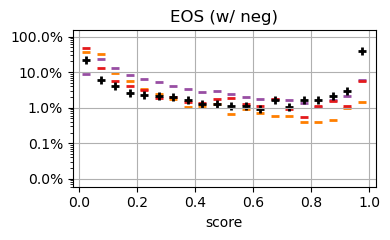

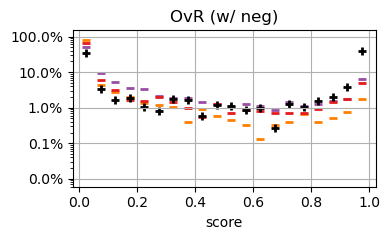

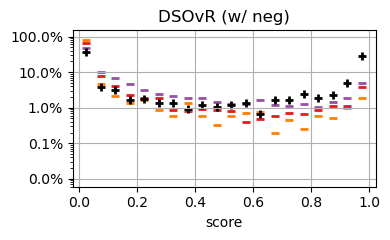

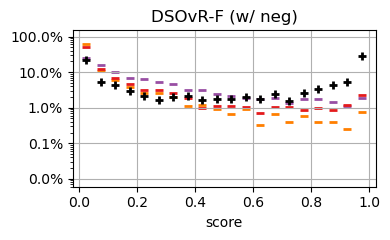

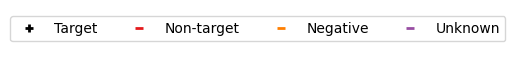

In [548]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[4],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=True)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[2], lw=0, label=labels[2], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

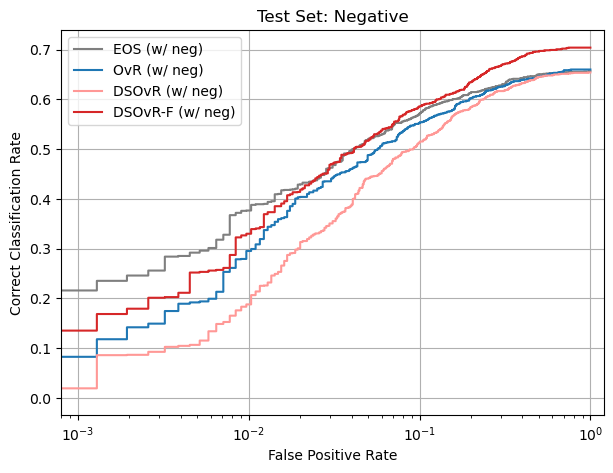

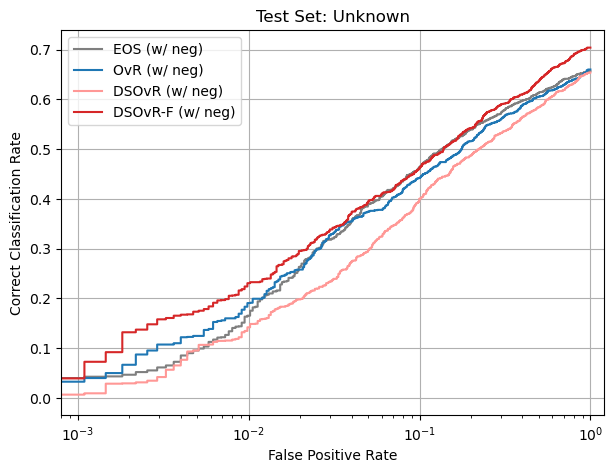

In [552]:
colors = [CMAP_t10[7]]+ [CMAP_t20[0]] + [CMAP_t20[7],CMAP_t20[6]]
evals.plot_OSCR(data_info, colors, figsize=(7,5), show_val=False)

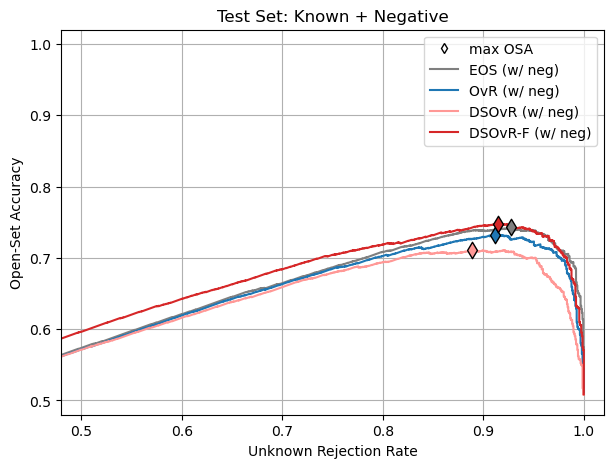

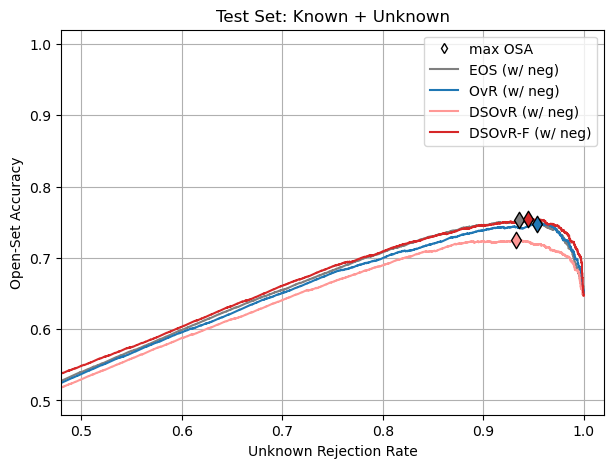

In [553]:
colors = [CMAP_t10[7]]+ [CMAP_t20[0]] + [CMAP_t20[7],CMAP_t20[6]]
evals.plot_OSAC(data_info, colors, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

#### Protocol 3

In [554]:
PROTOCOL = 3

##### OvR

In [555]:
data_info = ovr_data_info_2[PROTOCOL-1][:1] + ovr_data_info_3[PROTOCOL-1][:1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_neg_All', 'OvR']


In [556]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.0022	0.2766	0.6623	0.7314
0.0010	0.3640	0.7335	0.7343


In [557]:
data_info = ovr_data_info_2[PROTOCOL-1][1:2] + ovr_data_info_3[PROTOCOL-1][1:2]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_neg_All_g', 'OvR']


In [558]:
results_c = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.0710	0.0347	0.5473	0.6342
0.0190	0.1008	0.6873	0.6974


In [559]:
data_info = ovr_data_info_2[PROTOCOL-1][2:3] + ovr_data_info_3[PROTOCOL-1][2:3]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']


In [560]:
results_f = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.0020	0.2764	0.6687	0.7367
0.0010	0.3662	0.7281	0.7334


In [561]:
data_info = ovr_data_info_2[PROTOCOL-1][3:] + ovr_data_info_3[PROTOCOL-1][3:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ2', 'ResNet_50_M_neg_0_04', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_M_neg_All_06', 'OvR']


In [562]:
results_h = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.0050	0.1784	0.6669	0.7423
0.0020	0.2989	0.7281	0.7200


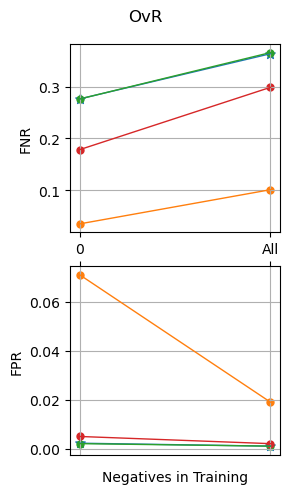

In [563]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0,0.42),(0,0.17)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['fnr_avg'] for r in res['res_fpr_fnr']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['fnr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)
    axs[1].plot([r['fpr_avg'] for r in res['res_fpr_fnr']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['fpr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)

axs[0].set_ylabel('FNR')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('FPR')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('OvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

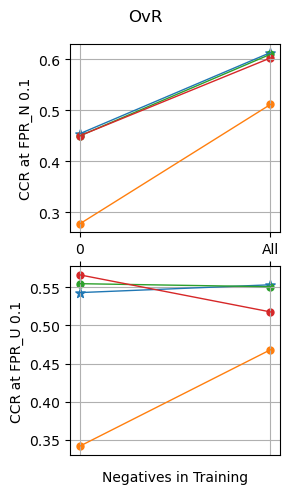

In [564]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0.3,0.75),(0.5,0.65)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['negative'] for r in res['oscr']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['negative'] for r in res['oscr']], marker=marker, s=size)
    axs[1].plot([r['unknown'] for r in res['oscr']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['unknown'] for r in res['oscr']], marker=marker, s=size)

axs[0].set_ylabel('CCR at FPR_N 0.1')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('CCR at FPR_U 0.1')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('OvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

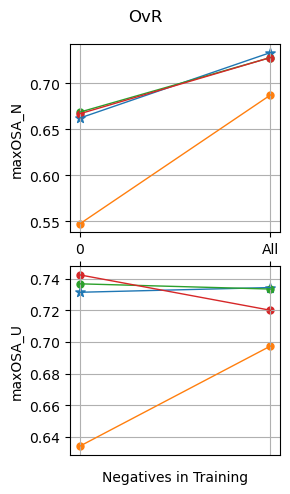

In [565]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0.55,0.8),(0.75,0.81)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['iosa_neg'] for r in res['oosa']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['iosa_neg'] for r in res['oosa']], marker=marker, s=size)
    axs[1].plot([r['iosa_unkn'] for r in res['oosa']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['iosa_unkn'] for r in res['oosa']], marker=marker, s=size)

axs[0].set_ylabel('maxOSA_N')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('maxOSA_U')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('OvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

##### DSOvR

In [566]:
data_info = dsovr_data_info_2[PROTOCOL-1][:1] + dsovr_data_info_3[PROTOCOL-1][:1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_neg_All', 'OpenSetOvR']


In [567]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.0024	0.2397	0.6592	0.7217
0.0010	0.3282	0.7586	0.7437


In [568]:
data_info = dsovr_data_info_2[PROTOCOL-1][1:2] + dsovr_data_info_3[PROTOCOL-1][1:2]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ2', 'ResNet_50_C_neg_0_g', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_neg_All_b', 'OpenSetOvR']


In [569]:
results_c = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.0468	0.0491	0.5179	0.5929
0.0154	0.0864	0.6585	0.6253


In [570]:
data_info = dsovr_data_info_2[PROTOCOL-1][2:3] + dsovr_data_info_3[PROTOCOL-1][2:3]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ2', 'ResNet_50_F_neg_0_1', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_F_neg_All_1', 'OpenSetOvR']


In [571]:
results_f = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.0031	0.2335	0.6597	0.7257
0.0010	0.3177	0.7673	0.7517


In [572]:
data_info = dsovr_data_info_2[PROTOCOL-1][3:] + dsovr_data_info_3[PROTOCOL-1][3:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ2', 'ResNet_50_M_neg_0_04', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_M_neg_All_06', 'OpenSetOvR']


In [573]:
results_h = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.0057	0.2030	0.5627	0.6486
0.0029	0.2772	0.6859	0.6617


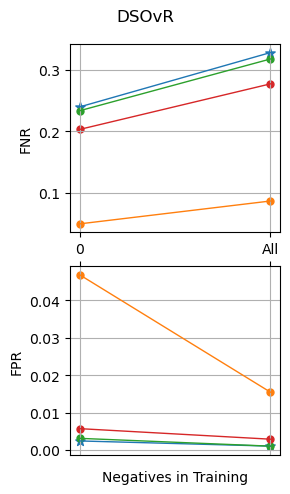

In [574]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0,0.42),(0,0.17)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['fnr_avg'] for r in res['res_fpr_fnr']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['fnr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)
    axs[1].plot([r['fpr_avg'] for r in res['res_fpr_fnr']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['fpr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)

axs[0].set_ylabel('FNR')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('FPR')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('DSOvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

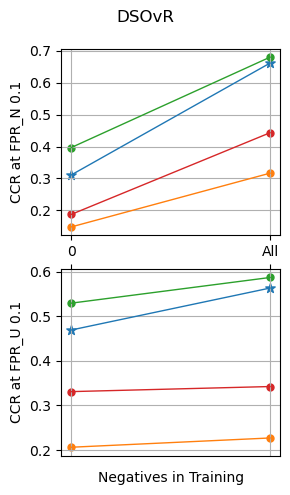

In [575]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0.3,0.75),(0.5,0.65)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['negative'] for r in res['oscr']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['negative'] for r in res['oscr']], marker=marker, s=size)
    axs[1].plot([r['unknown'] for r in res['oscr']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['unknown'] for r in res['oscr']], marker=marker, s=size)

axs[0].set_ylabel('CCR at FPR_N 0.1')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('CCR at FPR_U 0.1')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('DSOvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

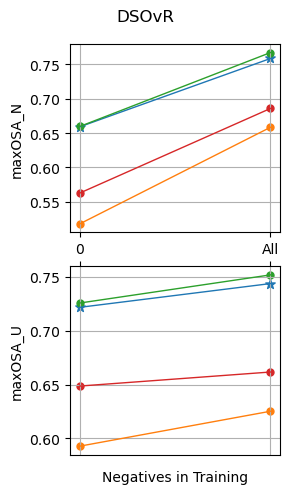

In [576]:
fig, axs = plt.subplots(2,1, figsize=(3,5))
ylim = [(0.55,0.8),(0.75,0.81)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['iosa_neg'] for r in res['oosa']], ls='-', lw=1, alpha=1)
    axs[0].scatter(x,[r['iosa_neg'] for r in res['oosa']], marker=marker, s=size)
    axs[1].plot([r['iosa_unkn'] for r in res['oosa']], ls='-', lw=1, alpha=1)
    axs[1].scatter(x,[r['iosa_unkn'] for r in res['oosa']], marker=marker, s=size)

axs[0].set_ylabel('maxOSA_N')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(2), ['0','All'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('maxOSA_U')
axs[1].set_xticks(range(2), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('DSOvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

##### Overall
- Negatives in training
- EOS vs. OvR vs. DSOvR vs. DSOvR-F

In [578]:
data_info = eos_data_info_3[PROTOCOL-1][-1:] + ovr_data_info_3[PROTOCOL-1][:1] + dsovr_data_info_3[PROTOCOL-1][:1] + dsovr_data_info_3[PROTOCOL-1][2:3]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ3', 'ResNet_50_neg_All', 'EOS']
['LargeScale_3', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_F_neg_All_1', 'OpenSetOvR']


In [579]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.0012	0.3336	0.7502	0.7420
0.0010	0.3640	0.7335	0.7343
0.0010	0.3282	0.7586	0.7437
0.0010	0.3177	0.7673	0.7517


[20.2781457   3.54966887  1.93377483  1.64238411] [71.36423841  6.05298013  3.15231788  2.17218543]
[27.33774834  2.21192053  1.52317881  0.98013245] [80.91390728  3.8807947   1.69536424  1.31125828]
[22.71523179  2.30463576  1.47019868  1.23178808] [81.82781457  3.61589404  2.35761589  1.11258278]
[16.22516556  3.36423841  2.46357616  1.85430464] [67.44370861  8.79470199  4.82119205  3.20529801]


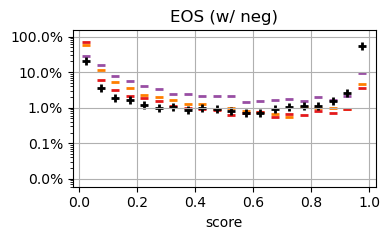

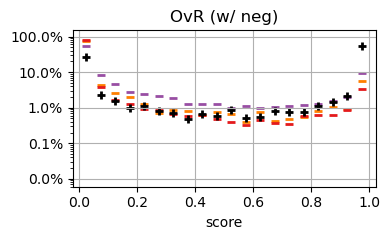

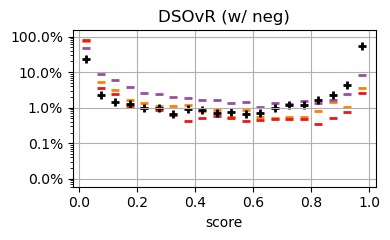

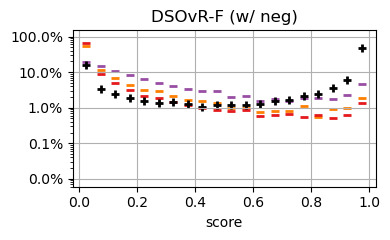

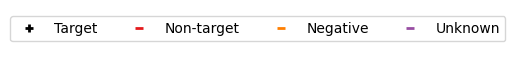

In [580]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[4],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=True)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[2], lw=0, label=labels[2], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

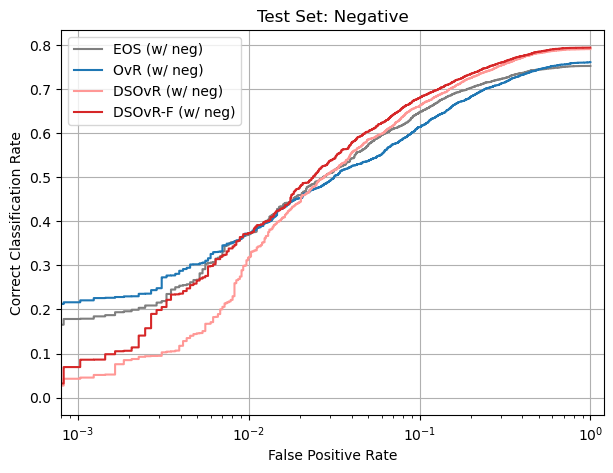

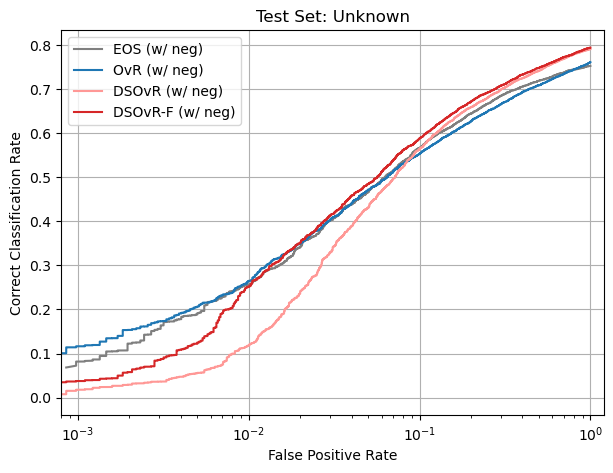

In [581]:
colors = [CMAP_t10[7]]+ [CMAP_t20[0]] + [CMAP_t20[7],CMAP_t20[6]]
evals.plot_OSCR(data_info, colors, figsize=(7,5), show_val=False)

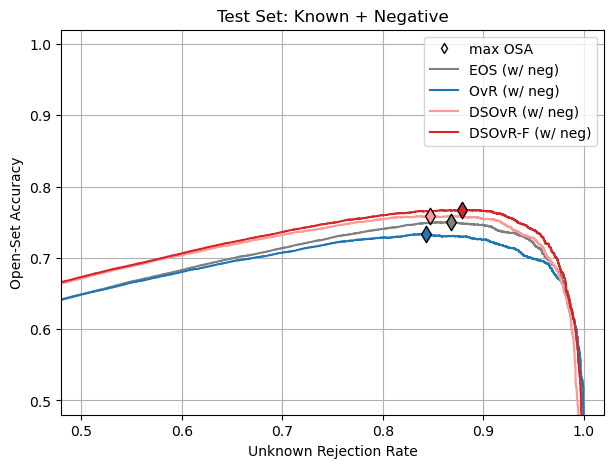

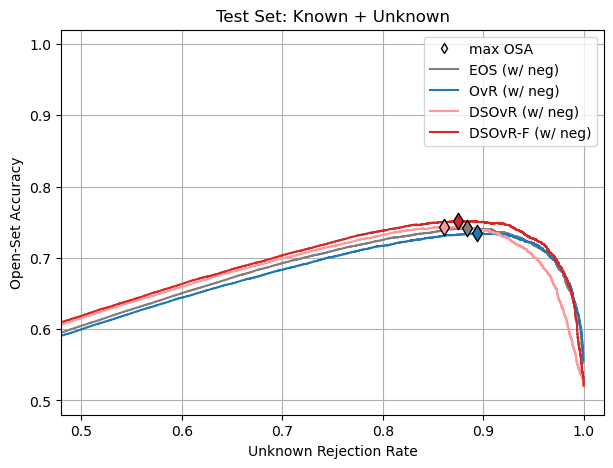

In [582]:
colors = [CMAP_t10[7]]+ [CMAP_t20[0]] + [CMAP_t20[7],CMAP_t20[6]]
evals.plot_OSAC(data_info, colors, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

### Appendix

In [258]:
log_item_list = [('Loss/train', 'Loss', 'Training Loss'),
                 ('Loss/val', 'Loss', 'Validation Loss'),
                 ('Acc/train', 'Accuracy', 'Training Acc.'),
                 ('Acc/val', 'Accuracy', 'Validation Acc.'),
                 ('Conf/train_kn', 'Confidence', 'Training Known Confidence.'),
                 ('Conf/train_neg', 'Confidence', 'Training Negative Confidence.'),
                 ('Conf/val_kn', 'Confidence', 'Validation Known Confidence.'),
                 ('Conf/val_neg', 'Confidence', 'Validation Negative Confidence.'),]

for idx, item in enumerate(log_item_list):
    print(f"{idx} : {item[0]}")

0 : Loss/train
1 : Loss/val
2 : Acc/train
3 : Acc/val
4 : Conf/train_kn
5 : Conf/train_neg
6 : Conf/val_kn
7 : Conf/val_neg


In [259]:
ITEM_IDX = 2
log_item_list[ITEM_IDX][0]

'Acc/train'

#### Protocol 1

In [ ]:
PROTOCOL = 1

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1]
data_info += dsovr_data_info_2[PROTOCOL-1] + dsovr_data_info_3_C[PROTOCOL-1]

plt.figure(figsize=(10,5))
for idx, d_i in enumerate(data_info):

    logs = evals.get_training_log(d_i, log_item)

    plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')


#### Protocol 2

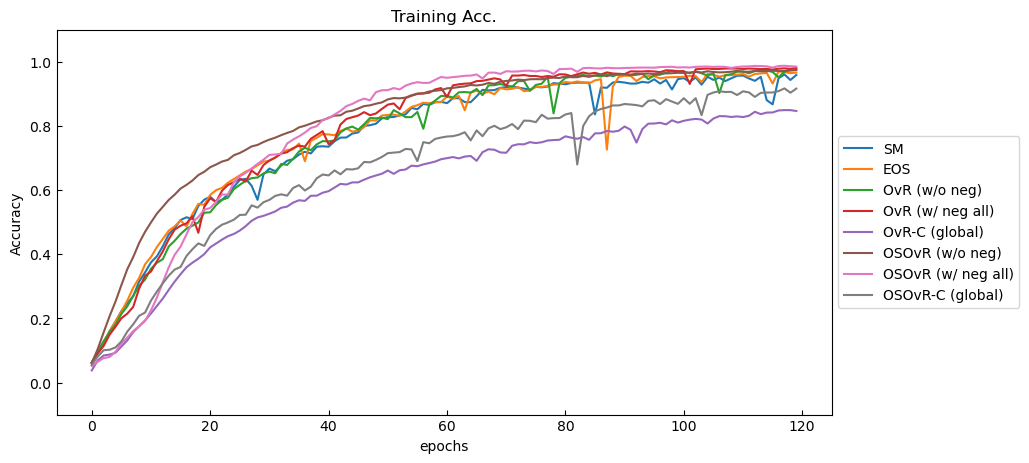

In [ ]:
PROTOCOL = 2

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1][-1:]
data_info += dsovr_data_info_2[PROTOCOL-1] + dsovr_data_info_3_C[PROTOCOL-1][-1:]

plt.figure(figsize=(10,5))
for idx, d_i in enumerate(data_info):

    logs = evals.get_training_log(d_i, log_item)

    plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')


#### Protocol 3

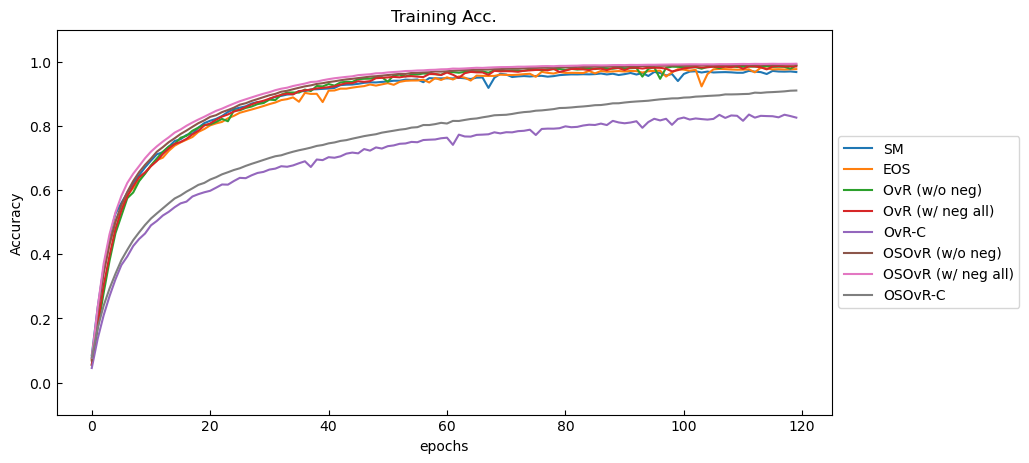

In [ ]:
PROTOCOL = 3

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1]
data_info += dsovr_data_info_2[PROTOCOL-1] + dsovr_data_info_3_C[PROTOCOL-1]

plt.figure(figsize=(10,5))
for idx, d_i in enumerate(data_info):

    logs = evals.get_training_log(d_i, log_item)

    plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')
